In [1]:
import importlib
import xarray as xr
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import colors
import matplotlib.gridspec as gridspec
import pandas as pd
from math import nan
import math
from glob import glob
import datetime as dt
import itertools

from CASutils import mapplot_utils as maps
from CASutils import filter_utils as filt 

from cmocean import cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

import metpy.calc as mpcalc
from metpy.units import units
import metpy

%matplotlib inline
sns.set_style("whitegrid")

importlib.reload(maps)
importlib.reload(filt)

<module 'CASutils.filter_utils' from '/home/dhruv/CASanalysis/CASutils/filter_utils.py'>

In [2]:
ps_files = ["/home/data/ERA5/PS_day/ps_{}.nc".format(i) for i in range(1979, 2020)]
ps = xr.open_mfdataset(ps_files)

In [3]:
levels = [700, 750, 800, 825, 850, 875, 900, 925, 950, 975]

q_files = dict()
for level in levels:
    q_files[level] = glob("/home/data/ERA5/Q_day/Q_{}mb/*.nc".format(level))

In [4]:
for level in levels:
    for i in q_files[level]:
        temp = xr.open_dataset(i)
        year = i[-13:-9]
        num_days = len(temp.time)
        times = pd.date_range("{}-01-01".format(year), periods=num_days)
        temp['time'] = times
        name = i[-15:]
        temp = temp.expand_dims('level')
        temp.to_netcdf("/home/dhruv/data/q_ps/ps_{}/".format(level) + name)

In [4]:
q_files = glob('/home/dhruv/data/q_ps/*/*.nc')
q = xr.open_mfdataset(q_files)

In [5]:
td2m_files = ["/home/data/ERA5/TD2m_day/td2m_{}.nc".format(i) for i in range(1979, 2020)]
td2m = xr.open_mfdataset(td2m_files)

In [6]:
t2m_files = ["/home/data/ERA5/day/T2m_day/t2m_{}.nc".format(i) for i in range(1979, 2020)]
t2m = xr.open_mfdataset(t2m_files).load()

In [7]:
def jja_std_anoms(data):
    data = data.sel(time=~((data.time.dt.month==2) & (data.time.dt.day == 29)))
    daystr = xr.DataArray(data.indexes['time'].strftime('%m-%d'), coords = data.time.coords, name="daystr")
    datseason = data.groupby(daystr).mean('time')
    harmonics = filt.calc_season_nharm(datseason, 4, dimtime=0)
    anoms = data.groupby(daystr)-harmonics
    jja_std = anoms.sel(time=anoms['time.season']=='JJA').std()
    std_anoms = anoms/jja_std
    return std_anoms

In [8]:
def remove_time_mean(x):
    return(x - x.mean(dim='time'))

def remove_annual_cycle(x):
#     return((x-x.groupby('time.month').mean()).drop('month'))
    return x.groupby('time.year').map(remove_time_mean)

In [9]:
def anomalies(data):
    data = data.sel(time=~((data.time.dt.month==2) & (data.time.dt.day == 29)))
    daystr = xr.DataArray(data.indexes['time'].strftime('%m-%d'), coords = data.time.coords, name="daystr")
    datseason = data.groupby(daystr).mean('time')
    harmonics = filt.calc_season_nharm(datseason, 4, dimtime=0)
    anoms = data.groupby(daystr)-harmonics
    return anoms

In [10]:
def humidity_profile(lat, lon, name=""):
    if lon < 0:
        lon = lon + 360
    
    t2m_data = t2m.t2m.sel(dict(lat=lat, lon=lon), method='nearest')
    t2m_anoms = remove_annual_cycle(jja_std_anoms(t2m_data))
    jja_t2m_anoms = t2m_anoms.sel(time=t2m_anoms['time.season']=='JJA')
    heatwave_days = jja_t2m_anoms[jja_t2m_anoms>=jja_t2m_anoms.quantile(0.90)].time.values
    
    surface_pressure = ps.ps.sel(dict(lat=lat, lon=lon), method='nearest').mean().compute().item()/100.
    
    td2m_data = td2m.td2m.sel(dict(lat=lat, lon=lon), method='nearest').load()
    surface_humidity = mpcalc.specific_humidity_from_dewpoint(surface_pressure*units.hPa, 
                                                          td2m_data*units.K)
    humidity_anoms = remove_annual_cycle(jja_std_anoms(surface_humidity))
    hw_humidity = humidity_anoms.sel(time=heatwave_days).mean().item()

    vert_profile = dict()
    for level in levels:
        if level > surface_pressure:
            break
        q_level = q.sel(level=level).sel(dict(lat=lat, lon=lon), method='nearest').load()
        q_level_anoms = remove_annual_cycle(jja_std_anoms(q_level.Q))
        vert_profile[level] = q_level_anoms.sel(time=heatwave_days).mean().item()
        
    plt.scatter(hw_humidity, surface_pressure, color='r')
    plt.scatter(vert_profile.values(), vert_profile.keys())
    plt.gca().invert_yaxis()
    plt.title("Vertical profile of humidity anomalies during heatwave days at"
              "\n {}; lat: {}, lon: {}".format(name, lat, lon))
    plt.show()

In [11]:
def get_heatwavedays(c_lat,c_lon):  
    if c_lon < 0:
        c_lon = c_lon + 360
    data = t2m.t2m.sel(dict(lat=c_lat, lon=c_lon), method='nearest')
    t2m_anoms = remove_annual_cycle(jja_std_anoms(data))
    jja_t2m_anoms = t2m_anoms.sel(time=t2m_anoms['time.season']=='JJA')
    heatwave_days = jja_t2m_anoms[jja_t2m_anoms>=jja_t2m_anoms.quantile(0.90)].time.values
    return(heatwave_days)

In [40]:
def gather_df_anoms(lat,lon):
    if lon < 0:
        lon = lon + 360
    surface_pressure = ps.ps.sel(dict(lat=lat,lon=lon),method='nearest').mean().compute().item()/100
    print("Surface Pressure: " + str(surface_pressure))

    # delete levels that are below surface pressure
    levels = pd.Series(q.level.values)
#     levels = list(levels[levels < surface_pressure])
    
    hwdays = get_heatwavedays(lat,lon)


    days = np.arange(-5,3)
    df = pd.DataFrame(np.nan, index=levels, columns=days)
    
    df = gather_anoms(lat,lon,df,hwdays,levels,days)
    
    return(df)

In [46]:
def gather_anoms(c_lat, c_lon,ddff,hwdays,levels,days):
    if c_lon < 0:
        c_lon = c_lon + 360
        
    for lev in levels:
        qv_level = q.sel(level=lev).sel(dict(lat=c_lat, lon=c_lon), method='nearest').load()
        # find anomalies for level
        qv_level_anoms = remove_annual_cycle(jja_std_anoms(qv_level.Q))
        print(lev)
        for day in days:
            try:
                # filter the anomalies for just the heatwave days
                ddff.loc[lev,day] = qv_level_anoms.sel(time=hwdays+ np.timedelta64(day,'D')).mean().item()

            except: 
                ddff.loc[lev,day] = nan
                
    surfpress = ps.ps.sel(dict(lat=c_lat, lon=c_lon), method='nearest').mean().compute().item()/100.
    dewval = td2m.td2m.sel(lat=c_lat,lon=c_lon,method='nearest').load()
        
    surfhum = mpcalc.specific_humidity_from_dewpoint(surfpress*units.hPa,dewval*units.K)
    surfhum_anoms = remove_annual_cycle(jja_std_anoms(surfhum))

    surf_hum_vals = []
    for day in days:
        val = surfhum_anoms.sel(time=hwdays+ np.timedelta64(day,'D')).mean().item()
        surf_hum_vals.append(float(val))
    
    ind = list(ddff.index)

    ind.append(1020)
    ind.sort()

    df = pd.DataFrame(np.nan, index=ind, columns=days)
    df.iloc[-1:,:] = pd.Series(surf_hum_vals)
    df.iloc[:-1,:] = ddff
    
#     ddff = ddff.set_index(new_ind[::-1])
    ddff = ddff.sort_index(ascending=True)


    return(ddff)

In [23]:
def meshplot(df,lat,lon,title=''):
    if lon < 0:
        lon = lon + 360
#     df = df.iloc[::-1]

#     df = df.iloc[::-1]

    lastrow = df.iloc[-1,:]

    display(df)
    display(lastrow)
    
    firstgraph = df.iloc[:-1,:]/lastrow

    display(firstgraph)

    widths = [1]
    heights = [10,1]

    fig2 = plt.figure(constrained_layout=True)
    spec2 = gridspec.GridSpec(ncols=1, nrows=2, figure=fig2, width_ratios=widths, height_ratios=heights )
    f2_ax1 = fig2.add_subplot(spec2[0, 0])
    final_row = np.array((lastrow,np.zeros(8)))
    
    f2_ax1.pcolormesh(np.array(firstgraph.columns),np.array(firstgraph.index) , firstgraph,  cmap ='YlOrRd' ,shading='auto')
    f2_ax1.set_ylim(firstgraph.index[0]-14, firstgraph.index[-1] + 4 )
    f2_ax1.axes.xaxis.set_visible(True)   
    f2_ax1.invert_yaxis()

    f2_ax2 = fig2.add_subplot(spec2[1, 0])
    f2_ax2.plot(lastrow.index,lastrow,color='black')
    surface_pressure = surface_pressure = ps.ps.sel(dict(lat=lat,lon=lon),method='nearest').mean().compute().item()/100
    f2_ax2.set_ylabel('SP: '+str(round(surface_pressure)) ,rotation='horizontal',ha='right', va='center')
    f2_ax2.axes.xaxis.set_ticks([])

    f2_ax1.set_title('ERA5 Humidity Anomalies at {}, {}'.format(lat,lon) + title)

In [14]:
lblue_coords = [(45, -116), (51, -101), (42, -98), (44, -91), (59, -74)]

In [17]:
lat, lon = lblue_coords[0]
df_lb0 = gather_df_anoms(lat,lon)

Surface Pressure: 838.5219763443237
700.0
750.0
800.0
825.0


,-5,-4,-3,-2,-1,0,1,2
700.000000,0.104515,0.108517,0.127144,0.256680,0.479591,0.699397,0.758035,0.568773
750.000000,0.065438,0.040410,-0.019398,-0.009616,0.079488,0.353880,0.506965,0.451871
800.000000,0.053378,0.042551,-0.005823,-0.029220,-0.040599,0.165995,0.396877,0.408004
825.000000,0.042087,0.037846,-0.012049,-0.071985,-0.116682,0.065090,0.380679,0.425113
838.521976,0.033002,0.029008,-0.010409,-0.061881,-0.082885,0.084907,0.397080,0.431654


-5    0.033002
-4    0.029008
-3   -0.010409
-2   -0.061881
-1   -0.082885
 0    0.084907
 1    0.397080
 2    0.431654
Name: 838.5219763443237, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,3.166923,3.740925,-12.215164,-4.147957,-5.786186,8.237215,1.909025,1.317661
750.0,1.982840,1.393064,1.863624,0.155398,-0.959006,4.167852,1.276734,1.046836
800.0,1.617420,1.466867,0.559478,0.472189,0.489818,1.955020,0.999490,0.945212
825.0,1.275282,1.304675,1.157544,1.163287,1.407746,0.766605,0.958697,0.984848


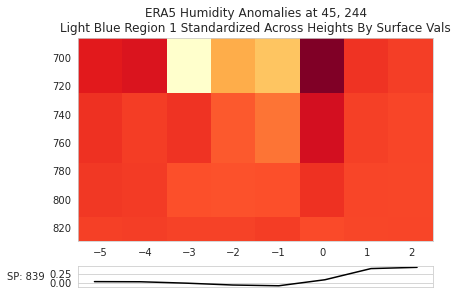

In [20]:
meshplot(df_lb0,lat,lon,title='\nLight Blue Region 1 Standardized Across Heights By Surface Vals')

,-5,-4,-3,-2,-1,0,1,2
700.000000,0.104515,0.108517,0.127144,0.256680,0.479591,0.699397,0.758035,0.568773
750.000000,0.065438,0.040410,-0.019398,-0.009616,0.079488,0.353880,0.506965,0.451871
800.000000,0.053378,0.042551,-0.005823,-0.029220,-0.040599,0.165995,0.396877,0.408004
825.000000,0.042087,0.037846,-0.012049,-0.071985,-0.116682,0.065090,0.380679,0.425113
838.521976,0.033002,0.029008,-0.010409,-0.061881,-0.082885,0.084907,0.397080,0.431654


-5    0.033002
-4    0.029008
-3   -0.010409
-2   -0.061881
-1   -0.082885
 0    0.084907
 1    0.397080
 2    0.431654
Name: 838.5219763443237, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,3.166923,3.740925,-12.215164,-4.147957,-5.786186,8.237215,1.909025,1.317661
750.0,1.982840,1.393064,1.863624,0.155398,-0.959006,4.167852,1.276734,1.046836
800.0,1.617420,1.466867,0.559478,0.472189,0.489818,1.955020,0.999490,0.945212
825.0,1.275282,1.304675,1.157544,1.163287,1.407746,0.766605,0.958697,0.984848


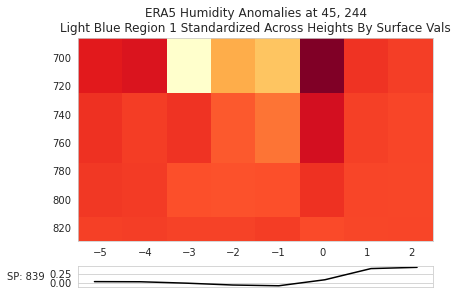

In [80]:
meshplot(df_lb0,lat,lon,title='\nLight Blue Region 1 Standardized Across Heights By Surface Vals')

Surface Pressure: 942.3197206518937
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0


,-5,-4,-3,-2,-1,0,1,2
700.000000,0.210800,0.233022,0.289833,0.468983,0.867109,1.334226,0.910286,0.400785
750.000000,-0.012513,0.059442,0.069381,0.053580,0.305392,0.669874,0.494019,0.221357
800.000000,0.032176,0.105430,0.138328,0.116127,0.343364,0.716744,0.547478,0.281971
825.000000,0.118484,0.166245,0.200489,0.232595,0.433984,0.816814,0.608573,0.324632
850.000000,0.143469,0.188098,0.225975,0.291054,0.520124,0.914564,0.644521,0.325398
875.000000,0.153775,0.186656,0.226325,0.321762,0.601381,1.025480,0.684702,0.311568
900.000000,0.157225,0.176094,0.210954,0.330995,0.658990,1.098569,0.722908,0.306691
925.000000,0.164039,0.171932,0.195031,0.325809,0.686067,1.150535,0.776630,0.324457
942.319721,0.172611,0.172571,0.195470,0.337553,0.707433,1.204500,0.853240,0.359066


-5    0.172611
-4    0.172571
-3    0.195470
-2    0.337553
-1    0.707433
 0    1.204500
 1    0.853240
 2    0.359066
Name: 942.3197206518937, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,1.221247,1.350296,1.482749,1.389361,1.225712,1.107700,1.066858,1.116187
750.0,-0.072495,0.344449,0.354942,0.158732,0.431691,0.556142,0.578992,0.616479
800.0,0.186408,0.610940,0.707671,0.344025,0.485366,0.595055,0.641645,0.785290
825.0,0.686424,0.963345,1.025675,0.689061,0.613463,0.678135,0.713249,0.904100
850.0,0.831174,1.089974,1.156062,0.862248,0.735227,0.759289,0.755381,0.906234
875.0,0.890879,1.081621,1.157852,0.953219,0.850089,0.851373,0.802473,0.867718
900.0,0.910865,1.020415,1.079218,0.980571,0.931523,0.912054,0.847250,0.854136
925.0,0.950340,0.996299,0.997754,0.965209,0.969798,0.955197,0.910212,0.903615


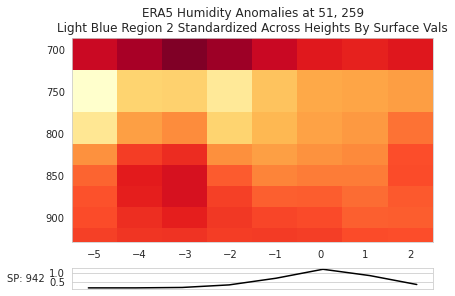

In [81]:
lat, lon = lblue_coords[1]
df_lb0 = gather_df_anoms(lat,lon)
meshplot(df_lb0,lat,lon,title='\nLight Blue Region 2 Standardized Across Heights By Surface Vals')

Surface Pressure: 955.9903703100056
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0


,-5,-4,-3,-2,-1,0,1,2
700.00000,0.120271,0.213126,0.292371,0.425319,0.739975,0.881779,0.655187,0.315501
750.00000,0.068207,0.081713,0.020948,0.057292,0.166009,0.366634,0.569845,0.367042
800.00000,0.056719,0.126436,0.037926,0.100242,0.233762,0.435840,0.587258,0.382379
825.00000,0.082509,0.159046,0.096440,0.118006,0.289753,0.477162,0.529421,0.309712
850.00000,0.091292,0.163226,0.136411,0.139229,0.348526,0.483763,0.507230,0.281204
875.00000,0.091121,0.156095,0.158324,0.173672,0.417373,0.506506,0.492695,0.269427
900.00000,0.105639,0.165470,0.175504,0.229029,0.500021,0.562629,0.499130,0.269137
925.00000,0.117987,0.184880,0.209092,0.284581,0.574451,0.661852,0.545176,0.293005
950.00000,0.122532,0.200259,0.241794,0.327754,0.624862,0.741665,0.604492,0.317400
955.99037,0.123745,0.202862,0.262480,0.365101,0.662974,0.789448,0.652937,0.333508


-5    0.123745
-4    0.202862
-3    0.262480
-2    0.365101
-1    0.662974
 0    0.789448
 1    0.652937
 2    0.333508
Name: 955.9903703100056, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,0.971927,1.050596,1.113877,1.164934,1.116145,1.116956,1.003445,0.946008
750.0,0.551188,0.402802,0.079806,0.156922,0.250400,0.464418,0.872741,1.100549
800.0,0.458352,0.623258,0.144489,0.274558,0.352595,0.552082,0.899410,1.146536
825.0,0.666764,0.784008,0.367418,0.323215,0.437051,0.604425,0.810829,0.928651
850.0,0.737744,0.804617,0.519701,0.381344,0.525702,0.612786,0.776843,0.843171
875.0,0.736363,0.769464,0.603186,0.475682,0.629546,0.641595,0.754582,0.807859
900.0,0.853683,0.815674,0.668637,0.627301,0.754209,0.712686,0.764438,0.806988
925.0,0.953473,0.911359,0.796602,0.779458,0.866477,0.838373,0.834959,0.878555
950.0,0.990201,0.987165,0.921191,0.897708,0.942514,0.939473,0.925804,0.951702


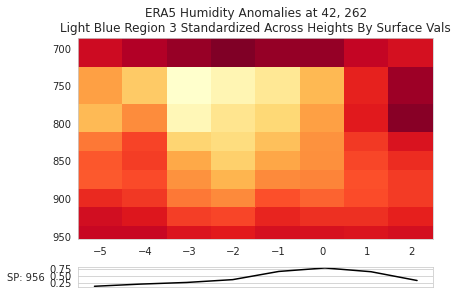

In [82]:
lat, lon = lblue_coords[2]
df_lb0 = gather_df_anoms(lat,lon)
meshplot(df_lb0,lat,lon,title='\nLight Blue Region 3 Standardized Across Heights By Surface Vals')

Surface Pressure: 981.6633820106065
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.000000,0.063061,0.150974,0.313197,0.584807,1.016211,1.362692,0.951202,0.450905
750.000000,0.030198,0.027295,0.133160,0.258852,0.475831,0.583170,0.484391,0.278947
800.000000,0.041101,0.040644,0.107570,0.248431,0.507973,0.665058,0.522299,0.266396
825.000000,0.078551,0.093986,0.134428,0.257865,0.558856,0.762668,0.561253,0.259746
850.000000,0.075586,0.124550,0.181416,0.309540,0.627592,0.857348,0.629685,0.296638
875.000000,0.079737,0.143304,0.214974,0.382919,0.723678,0.989212,0.719919,0.348607
900.000000,0.062722,0.136513,0.236701,0.453723,0.816391,1.101763,0.788404,0.389213
925.000000,0.054390,0.124446,0.249765,0.483296,0.870784,1.168070,0.821956,0.399848
950.000000,0.046467,0.116126,0.249807,0.486805,0.892610,1.211365,0.858324,0.406043
975.000000,0.037724,0.107994,0.249600,0.490745,0.899337,1.236590,0.895903,0.420428


-5    0.040351
-4    0.108852
-3    0.253871
-2    0.508697
-1    0.907483
 0    1.244344
 1    0.927163
 2    0.440532
Name: 981.6633820106065, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,1.562839,1.386971,1.233684,1.149616,1.119813,1.095108,1.025927,1.023546
750.0,0.748390,0.250754,0.524517,0.508853,0.524341,0.468656,0.522444,0.633206
800.0,1.018589,0.373387,0.423720,0.488368,0.559760,0.534465,0.563330,0.604715
825.0,1.946715,0.863427,0.529513,0.506912,0.615831,0.612907,0.605345,0.589619
850.0,1.873223,1.144214,0.714598,0.608496,0.691574,0.688995,0.679152,0.673362
875.0,1.976102,1.316505,0.846786,0.752744,0.797456,0.794967,0.776475,0.791331
900.0,1.554439,1.254116,0.932367,0.891931,0.899621,0.885416,0.850340,0.883506
925.0,1.347925,1.143263,0.983825,0.950065,0.959559,0.938703,0.886528,0.907648
950.0,1.151573,1.066829,0.983991,0.956963,0.983610,0.973496,0.925752,0.921710
975.0,0.934895,0.992119,0.983178,0.964709,0.991023,0.993768,0.966284,0.954363


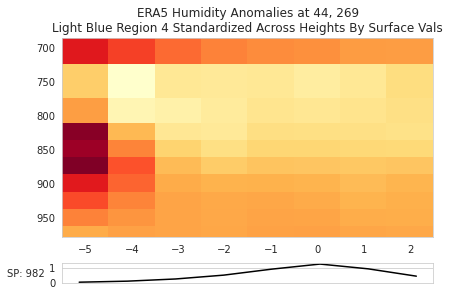

In [83]:
lat, lon = lblue_coords[3]
df_lb0 = gather_df_anoms(lat,lon)
meshplot(df_lb0,lat,lon,title='\nLight Blue Region 4 Standardized Across Heights By Surface Vals')

Surface Pressure: 985.3141454538647
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.000000,0.210470,0.266978,0.327734,0.541539,0.981405,1.608627,1.284210,0.705806
750.000000,0.136387,0.090177,0.011351,0.029699,0.191174,0.588337,0.658652,0.449483
800.000000,0.134789,0.075870,0.025866,0.064078,0.228563,0.703035,0.763908,0.503371
825.000000,0.130552,0.087245,0.038532,0.101180,0.309556,0.839403,0.868916,0.539541
850.000000,0.123252,0.098725,0.046595,0.121543,0.359688,0.931735,0.926303,0.552766
875.000000,0.112586,0.110644,0.063450,0.156129,0.424179,1.034683,0.992215,0.576884
900.000000,0.118845,0.135720,0.100766,0.205993,0.510436,1.125518,1.055414,0.610228
925.000000,0.131804,0.175516,0.160873,0.276470,0.619922,1.212449,1.107097,0.643579
950.000000,0.137232,0.196874,0.198715,0.331563,0.717430,1.304371,1.157356,0.656899
975.000000,0.129315,0.188893,0.202896,0.353440,0.750066,1.374882,1.197249,0.671304


-5    0.122404
-4    0.177605
-3    0.205731
-2    0.375929
-1    0.770724
 0    1.432448
 1    1.239590
 2    0.692497
Name: 985.3141454538647, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,1.719465,1.503209,1.593018,1.440534,1.273355,1.122991,1.035996,1.019219
750.0,1.114239,0.507740,0.055176,0.079002,0.248044,0.410721,0.531346,0.649077
800.0,1.101184,0.427186,0.125727,0.170453,0.296556,0.490793,0.616259,0.726892
825.0,1.066565,0.491227,0.187294,0.269146,0.401643,0.585992,0.700970,0.779124
850.0,1.006924,0.555869,0.226484,0.323313,0.466688,0.650449,0.747266,0.798221
875.0,0.919786,0.622977,0.308413,0.415314,0.550364,0.722318,0.800439,0.833049
900.0,0.970925,0.764165,0.489795,0.547956,0.662281,0.785730,0.851422,0.881200
925.0,1.076796,0.988236,0.781959,0.735432,0.804337,0.846417,0.893116,0.929360
950.0,1.121140,1.108491,0.965894,0.881983,0.930852,0.910589,0.933661,0.948595
975.0,1.056463,1.063553,0.986217,0.940177,0.973197,0.959813,0.965843,0.969397


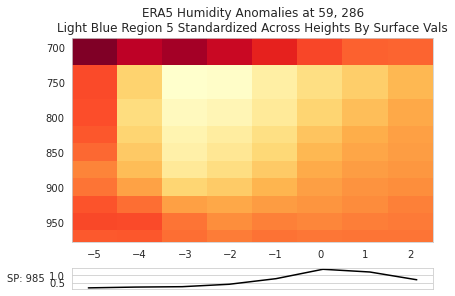

In [84]:
lat, lon = lblue_coords[4]
df_lb0 = gather_df_anoms(lat,lon)
meshplot(df_lb0,lat,lon,title='\nLight Blue Region 5 Standardized Across Heights By Surface Vals')

In [15]:
pink_coords = [(53, -123), (40.5, -109), (29, -106), (32, -96), (34, -86)]

Surface Pressure: 914.4839139023477
700.0
750.0
800.0
825.0
850.0
875.0
900.0


,-5,-4,-3,-2,-1,0,1,2
700.000000,-0.086893,-0.066050,0.010357,0.184938,0.449933,0.668998,0.637361,0.399497
750.000000,-0.131175,-0.128039,-0.175332,-0.029678,0.293716,0.649247,0.669418,0.540914
800.000000,-0.093693,-0.099853,-0.087582,0.046881,0.269985,0.570119,0.629873,0.501185
825.000000,-0.101104,-0.093258,-0.063238,0.037569,0.184859,0.448017,0.591061,0.468880
850.000000,-0.106973,-0.105908,-0.074344,0.016108,0.149795,0.410769,0.576463,0.458081
875.000000,-0.118182,-0.123127,-0.097783,-0.014866,0.122631,0.392799,0.566758,0.449468
900.000000,-0.132620,-0.138205,-0.118230,-0.033459,0.117495,0.393508,0.567295,0.438567
914.483914,-0.148931,-0.156057,-0.136886,-0.039199,0.139030,0.404038,0.572545,0.425600


-5   -0.148931
-4   -0.156057
-3   -0.136886
-2   -0.039199
-1    0.139030
 0    0.404038
 1    0.572545
 2    0.425600
Name: 914.4839139023477, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,0.583447,0.423243,-0.075663,-4.717971,3.236232,1.655782,1.113207,0.938668
750.0,0.880777,0.820466,1.280863,0.757112,2.112611,1.606896,1.169198,1.270944
800.0,0.629104,0.639853,0.639816,-1.195978,1.941922,1.411054,1.100128,1.177595
825.0,0.678866,0.597592,0.461979,-0.958424,1.329634,1.108850,1.032340,1.101691
850.0,0.718274,0.678649,0.543107,-0.410937,1.077429,1.016660,1.006843,1.076317
875.0,0.793537,0.788985,0.714337,0.379258,0.882049,0.972184,0.989894,1.056080
900.0,0.890479,0.885609,0.863710,0.853581,0.845107,0.973939,0.990832,1.030466


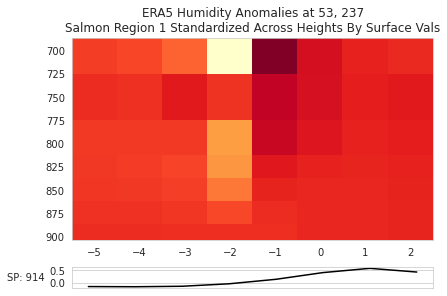

In [86]:
lat, lon = pink_coords[0]
df_lb0 = gather_df_anoms(lat,lon)
meshplot(df_lb0,lat,lon,title='\nSalmon Region 1 Standardized Across Heights By Surface Vals')

Surface Pressure: 807.1943767788475
700.0
750.0
800.0


,-5,-4,-3,-2,-1,0,1,2
700.000000,-0.284609,-0.300596,-0.312972,-0.362308,-0.425067,-0.418041,-0.177930,0.014836
750.000000,-0.238679,-0.266952,-0.281280,-0.350448,-0.427811,-0.358907,-0.075080,0.107381
800.000000,-0.254752,-0.274318,-0.297892,-0.376928,-0.467815,-0.407948,-0.116140,0.069661
807.194377,-0.274024,-0.290162,-0.317353,-0.397653,-0.490208,-0.450471,-0.166659,0.035853


-5   -0.274024
-4   -0.290162
-3   -0.317353
-2   -0.397653
-1   -0.490208
 0   -0.450471
 1   -0.166659
 2    0.035853
Name: 807.1943767788475, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,1.038627,1.035959,0.986194,0.911117,0.867117,0.928009,1.067630,0.413801
750.0,0.871015,0.920009,0.886332,0.881292,0.872713,0.796737,0.450501,2.995042
800.0,0.929670,0.945397,0.938676,0.947881,0.954321,0.905603,0.696872,1.942957


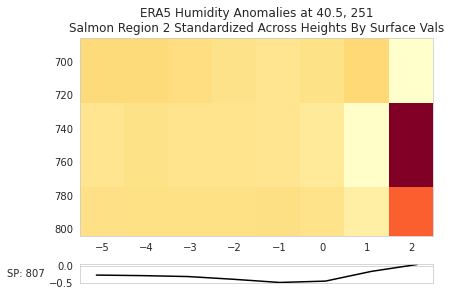

In [87]:
lat, lon = pink_coords[1]
df_lb0 = gather_df_anoms(lat,lon)
meshplot(df_lb0,lat,lon,title='\nSalmon Region 2 Standardized Across Heights By Surface Vals')

Surface Pressure: 825.572960311619
700.0
750.0
800.0
825.0


,-5,-4,-3,-2,-1,0,1,2
700.00000,-0.365124,-0.453751,-0.558145,-0.733465,-0.938790,-1.022218,-0.824622,-0.593833
750.00000,-0.216459,-0.317672,-0.445530,-0.625905,-0.858917,-0.909995,-0.662069,-0.399499
800.00000,-0.329305,-0.416927,-0.541307,-0.721356,-0.938123,-0.995881,-0.749644,-0.493229
825.00000,-0.369032,-0.458026,-0.568853,-0.752116,-0.970499,-1.025497,-0.765187,-0.518380
825.57296,-0.369362,-0.463720,-0.578033,-0.761251,-0.970980,-1.049620,-0.798868,-0.556924


-5   -0.369362
-4   -0.463720
-3   -0.578033
-2   -0.761251
-1   -0.970980
 0   -1.049620
 1   -0.798868
 2   -0.556924
Name: 825.572960311619, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,0.988525,0.978501,0.965594,0.963499,0.966847,0.973894,1.032239,1.066274
750.0,0.586033,0.685050,0.770770,0.822205,0.884587,0.866976,0.828760,0.717332
800.0,0.891549,0.899091,0.936465,0.947593,0.966161,0.948802,0.938383,0.885632
825.0,0.999106,0.987719,0.984119,0.988000,0.999505,0.977018,0.957839,0.930792


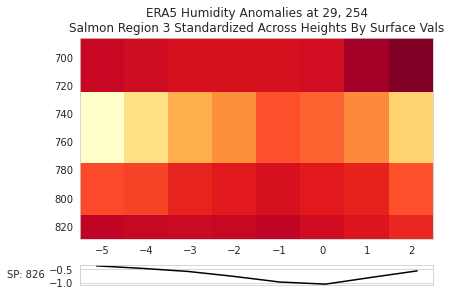

In [88]:
lat, lon = pink_coords[2]
df_lb0 = gather_df_anoms(lat,lon)
meshplot(df_lb0,lat,lon,title='\nSalmon Region 3 Standardized Across Heights By Surface Vals')

Surface Pressure: 1000.7158952435931
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.000000,-0.067707,-0.078531,-0.085532,-0.122328,-0.139204,-0.118725,-0.115487,-0.147493
750.000000,0.001072,-0.025025,-0.093666,-0.138522,-0.164788,-0.090675,0.035324,0.074397
800.000000,-0.001123,-0.026164,-0.117759,-0.150236,-0.120061,0.052434,0.172579,0.187305
825.000000,0.073348,0.043954,-0.012544,-0.047405,0.054767,0.270035,0.361843,0.332853
850.000000,0.108299,0.079890,0.044334,0.019676,0.126773,0.308076,0.370665,0.350915
875.000000,0.098773,0.074281,0.051729,0.032868,0.138600,0.279351,0.311351,0.296793
900.000000,0.048167,0.018683,0.002952,-0.018527,0.069096,0.175192,0.211564,0.205918
925.000000,-0.009294,-0.030305,-0.033066,-0.054892,-0.004852,0.071832,0.120508,0.125765
950.000000,-0.029579,-0.035603,-0.042331,-0.060833,-0.050401,-0.001387,0.058627,0.063896
975.000000,-0.007867,-0.003225,-0.014900,-0.045449,-0.069501,-0.040811,0.031202,0.025682


-5   -0.008405
-4   -0.011440
-3   -0.020218
-2   -0.052725
-1   -0.088109
 0   -0.081695
 1   -0.003687
 2   -0.011716
Name: 1000.7158952435931, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,8.055924,6.864800,4.230477,2.320123,1.579898,1.453269,31.325366,12.588841
750.0,-0.127503,2.187587,4.632794,2.627268,1.870274,1.109918,-9.581427,-6.349951
800.0,0.133636,2.287146,5.824475,2.849426,1.362641,-0.641831,-46.811341,-15.986905
825.0,-8.727071,-3.842253,0.620452,0.899107,-0.621584,-3.305396,-98.148419,-28.409789
850.0,-12.885633,-6.983642,-2.192820,-0.373189,-1.438814,-3.771051,-100.541427,-29.951452
875.0,-11.752300,-6.493303,-2.558570,-0.623391,-1.573050,-3.419432,-84.452737,-25.331941
900.0,-5.731070,-1.633188,-0.146001,0.351382,-0.784206,-2.144462,-57.386064,-17.575569
925.0,1.105845,2.649143,1.635501,1.041098,0.055066,-0.879270,-32.687361,-10.734333
950.0,3.519322,3.112233,2.093740,1.153777,0.572027,0.016980,-15.902426,-5.453671
975.0,0.936032,0.281881,0.736975,0.862006,0.788802,0.499548,-8.463453,-2.192031


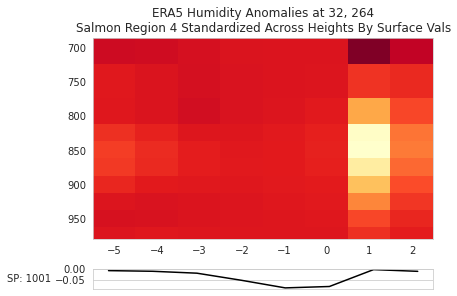

In [89]:
lat, lon = pink_coords[3]
df_lb0 = gather_df_anoms(lat,lon)
meshplot(df_lb0,lat,lon,title='\nSalmon Region 4 Standardized Across Heights By Surface Vals')

Surface Pressure: 985.9539293000547
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.000000,0.323438,0.323785,0.356484,0.436604,0.566957,0.694632,0.561540,0.318469
750.000000,0.076637,0.046524,0.050127,0.060959,0.094835,0.132214,0.177405,0.123493
800.000000,0.118264,0.078527,0.089367,0.113064,0.178263,0.268727,0.305545,0.187972
825.000000,0.196571,0.206976,0.254130,0.290761,0.385758,0.540669,0.571458,0.389923
850.000000,0.279260,0.308468,0.370515,0.412532,0.515005,0.690447,0.683816,0.482750
875.000000,0.341988,0.367287,0.425261,0.464581,0.565857,0.724910,0.694902,0.502875
900.000000,0.343517,0.361567,0.396285,0.426163,0.499349,0.628778,0.604955,0.443606
925.000000,0.300817,0.318122,0.334046,0.356032,0.394795,0.503922,0.509495,0.376854
950.000000,0.261163,0.283187,0.288850,0.300751,0.316136,0.409269,0.446269,0.334089
975.000000,0.239702,0.256657,0.260808,0.259466,0.263317,0.351810,0.419144,0.320675


-5    0.237319
-4    0.245662
-3    0.246892
-2    0.244218
-1    0.271018
 0    0.378925
 1    0.443025
 2    0.334225
Name: 985.9539293000547, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,1.362883,1.318011,1.443887,1.787763,2.091954,1.833165,1.267513,0.952860
750.0,0.322930,0.189381,0.203033,0.249610,0.349922,0.348920,0.400441,0.369490
800.0,0.498332,0.319654,0.361967,0.462962,0.657753,0.709182,0.689680,0.562413
825.0,0.828301,0.842523,1.029319,1.190580,1.423367,1.426849,1.289900,1.166649
850.0,1.176729,1.255660,1.500719,1.689196,1.900260,1.822121,1.543515,1.444389
875.0,1.441051,1.495094,1.722459,1.902319,2.087893,1.913070,1.568540,1.504601
900.0,1.447491,1.471809,1.605097,1.745012,1.842495,1.659373,1.365511,1.327269
925.0,1.267564,1.294959,1.353006,1.457845,1.456711,1.329872,1.150037,1.127546
950.0,1.100472,1.152751,1.169947,1.231487,1.166477,1.080080,1.007323,0.999594
975.0,1.010043,1.044757,1.056366,1.062437,0.971584,0.928441,0.946096,0.959460


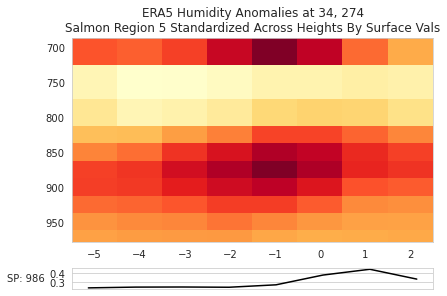

In [90]:
lat, lon = pink_coords[4]
df_lb0 = gather_df_anoms(lat,lon)
meshplot(df_lb0,lat,lon,title='\nSalmon Region 5 Standardized Across Heights By Surface Vals')

In [16]:
red_coords = [(62, -129), (54, -121), (56.5, -111), (39, -81), (43, -73)]

Surface Pressure: 838.0952964566208
700.0
750.0
800.0
825.0


,-5,-4,-3,-2,-1,0,1,2
700.000000,0.189009,0.246340,0.295025,0.411161,0.569398,0.770213,0.927237,0.745177
750.000000,0.158803,0.158767,0.180913,0.376541,0.596799,0.966135,1.027214,0.873010
800.000000,0.225216,0.262540,0.325149,0.514501,0.744562,1.032166,1.095398,0.871266
825.000000,0.164804,0.209827,0.254239,0.362347,0.508507,0.727392,0.901693,0.727722
838.095296,0.145801,0.186367,0.219011,0.311549,0.448089,0.641296,0.850892,0.698038


-5    0.145801
-4    0.186367
-3    0.219011
-2    0.311549
-1    0.448089
 0    0.641296
 1    0.850892
 2    0.698038
Name: 838.0952964566208, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,1.296348,1.321802,1.347078,1.319731,1.270725,1.201026,1.089723,1.067530
750.0,1.089174,0.851908,0.826046,1.208607,1.331874,1.506537,1.207219,1.250662
800.0,1.544677,1.408728,1.484623,1.651427,1.661638,1.609501,1.287352,1.248163
825.0,1.130331,1.125882,1.160851,1.163050,1.134834,1.134254,1.059703,1.042524


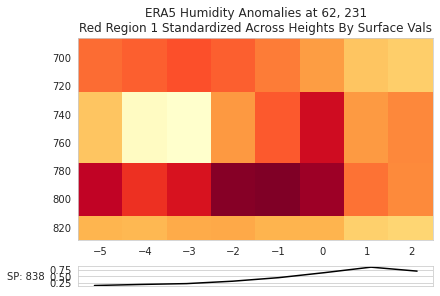

In [92]:
lat, lon = red_coords[0]
df_lb0 = gather_df_anoms(lat,lon)
meshplot(df_lb0,lat,lon,title='\nRed Region 1 Standardized Across Heights By Surface Vals')

Surface Pressure: 876.3568825410964
700.0
750.0
800.0
825.0
850.0
875.0


,-5,-4,-3,-2,-1,0,1,2
700.000000,-0.020855,0.022702,0.133454,0.309192,0.624854,1.070940,1.068106,0.710300
750.000000,-0.059311,-0.119386,-0.123751,-0.096176,0.171943,0.607633,0.666457,0.554453
800.000000,-0.009562,-0.022977,0.000757,0.051582,0.229589,0.621360,0.746989,0.625409
825.000000,-0.059015,-0.031746,0.020223,0.069374,0.170711,0.519795,0.756227,0.618867
850.000000,-0.084041,-0.046078,0.005308,0.057484,0.143925,0.488189,0.755722,0.609219
875.000000,-0.101882,-0.060226,-0.016019,0.044265,0.145354,0.488415,0.761383,0.609942
876.356883,-0.097886,-0.065756,-0.014390,0.090018,0.314497,0.752247,0.930877,0.670286


-5   -0.097886
-4   -0.065756
-3   -0.014390
-2    0.090018
-1    0.314497
 0    0.752247
 1    0.930877
 2    0.670286
Name: 876.3568825410964, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,0.213058,-0.345245,-9.274001,3.434772,1.986838,1.423655,1.147420,1.059697
750.0,0.605927,1.815583,8.599750,-1.068404,0.546726,0.807757,0.715946,0.827188
800.0,0.097689,0.349435,-0.052590,0.573014,0.730021,0.826006,0.802457,0.933048
825.0,0.602900,0.482787,-1.405344,0.770670,0.542807,0.690990,0.812382,0.923288
850.0,0.858563,0.700743,-0.368858,0.638576,0.457637,0.648975,0.811839,0.908894
875.0,1.040832,0.915904,1.113199,0.491732,0.462181,0.649275,0.817920,0.909973


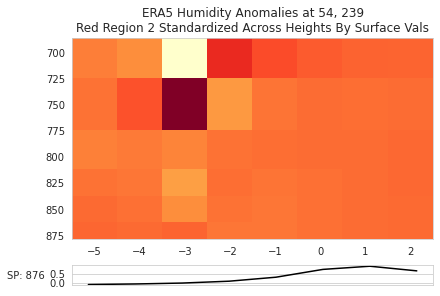

In [93]:
lat, lon = red_coords[1]
df_lb0 = gather_df_anoms(lat,lon)
meshplot(df_lb0,lat,lon,title='\nRed Region 2 Standardized Across Heights By Surface Vals')

Surface Pressure: 937.8167519810963
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0


,-5,-4,-3,-2,-1,0,1,2
700.000000,0.207962,0.167191,0.179471,0.284775,0.618197,0.989304,0.863190,0.481276
750.000000,0.091192,-0.012586,-0.073220,-0.091202,0.082812,0.556314,0.597796,0.395193
800.000000,0.110486,0.049798,-0.000657,0.041698,0.264464,0.718949,0.757191,0.476936
825.000000,0.151331,0.111236,0.074174,0.161386,0.428547,0.799411,0.816424,0.505561
850.000000,0.161644,0.113827,0.080531,0.162490,0.429230,0.781461,0.778800,0.473714
875.000000,0.164320,0.106240,0.069403,0.140471,0.403392,0.749518,0.733403,0.434269
900.000000,0.163099,0.097210,0.051449,0.108168,0.367169,0.718808,0.699736,0.411310
925.000000,0.158478,0.086200,0.031757,0.073849,0.335451,0.710004,0.702853,0.414987
937.816752,0.155544,0.080721,0.031939,0.073598,0.356895,0.765033,0.770592,0.454009


-5    0.155544
-4    0.080721
-3    0.031939
-2    0.073598
-1    0.356895
 0    0.765033
 1    0.770592
 2    0.454009
Name: 937.8167519810963, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,1.337001,2.071222,5.619162,3.869333,1.732153,1.293153,1.120164,1.060059
750.0,0.586279,-0.155915,-2.292493,-1.239189,0.232034,0.727177,0.775762,0.870452
800.0,0.710322,0.616912,-0.020557,0.566568,0.741015,0.939763,0.982610,1.050500
825.0,0.972913,1.378035,2.322363,2.192802,1.200764,1.044937,1.059476,1.113549
850.0,1.039220,1.410138,2.521393,2.207806,1.202680,1.021475,1.010651,1.043404
875.0,1.056419,1.316138,2.172980,1.908625,1.130283,0.979720,0.951739,0.956521
900.0,1.048571,1.204274,1.610845,1.469716,1.028786,0.939578,0.908050,0.905953
925.0,1.018864,1.067875,0.994287,1.003410,0.939914,0.928071,0.912095,0.914050


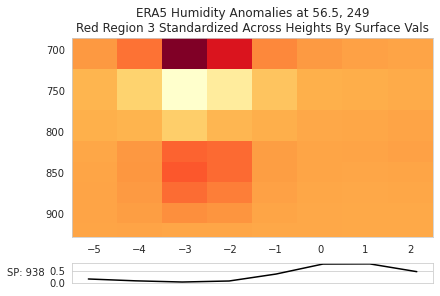

In [94]:
lat, lon = red_coords[2]
df_lb0 = gather_df_anoms(lat,lon)
meshplot(df_lb0,lat,lon,title='\nRed Region 3 Standardized Across Heights By Surface Vals')

Surface Pressure: 984.3076660648521
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.000000,0.097793,0.152543,0.235490,0.403095,0.700375,0.976325,0.816184,0.412461
750.000000,0.034826,0.042468,0.036357,0.100483,0.313544,0.501835,0.586549,0.307733
800.000000,0.063815,0.054150,0.040352,0.130938,0.394275,0.632235,0.672781,0.356892
825.000000,0.109202,0.106667,0.121905,0.196757,0.505789,0.792798,0.770268,0.396986
850.000000,0.119195,0.136563,0.177453,0.250100,0.570461,0.891899,0.840519,0.439754
875.000000,0.113328,0.151896,0.218613,0.301753,0.613596,0.950957,0.871731,0.467919
900.000000,0.107391,0.152341,0.227760,0.326219,0.627131,0.945303,0.859498,0.470181
925.000000,0.096915,0.142125,0.211651,0.324757,0.597969,0.896441,0.826687,0.461162
950.000000,0.088379,0.128954,0.191073,0.306283,0.563261,0.854447,0.802388,0.456000
975.000000,0.080781,0.113608,0.170116,0.280804,0.531321,0.827518,0.793809,0.456073


-5    0.072506
-4    0.099411
-3    0.155703
-2    0.270240
-1    0.527854
 0    0.826777
 1    0.796735
 2    0.454537
Name: 984.3076660648521, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,1.348763,1.534468,1.512430,1.491618,1.326834,1.180880,1.024411,0.907431
750.0,0.480315,0.427199,0.233499,0.371828,0.593997,0.606977,0.736191,0.677025
800.0,0.880140,0.544709,0.259158,0.484523,0.746939,0.764698,0.844423,0.785177
825.0,1.506109,1.072985,0.782934,0.728081,0.958198,0.958901,0.966781,0.873384
850.0,1.643939,1.373726,1.139690,0.925474,1.080716,1.078766,1.054955,0.967476
875.0,1.563023,1.527958,1.404038,1.116610,1.162435,1.150197,1.094129,1.029440
900.0,1.481139,1.532440,1.462785,1.207143,1.188077,1.143358,1.078776,1.034416
925.0,1.336652,1.429670,1.359325,1.201736,1.132830,1.084259,1.037594,1.014575
950.0,1.218925,1.297179,1.227166,1.133371,1.067077,1.033466,1.007095,1.003218
975.0,1.114137,1.142806,1.092564,1.039089,1.006568,1.000895,0.996328,1.003379


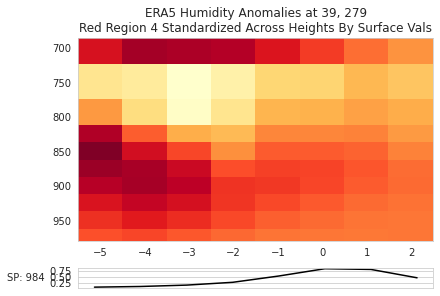

In [95]:
lat, lon = red_coords[3]
df_lb0 = gather_df_anoms(lat,lon)
meshplot(df_lb0,lat,lon,title='\nRed Region 4 Standardized Across Heights By Surface Vals')

Surface Pressure: 980.4106550850437
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.000000,-0.074734,-0.033447,0.155423,0.429708,0.849706,1.184785,0.831507,0.311667
750.000000,-0.074567,-0.135110,-0.032632,0.096336,0.388138,0.580204,0.408942,0.168641
800.000000,-0.091487,-0.147872,-0.030554,0.117671,0.430506,0.672884,0.462764,0.182496
825.000000,-0.102209,-0.112240,0.015111,0.233682,0.592819,0.871404,0.613084,0.277320
850.000000,-0.099362,-0.077608,0.055712,0.309988,0.701302,1.003611,0.714363,0.324242
875.000000,-0.097300,-0.060774,0.086026,0.358790,0.773835,1.092911,0.786733,0.344035
900.000000,-0.094071,-0.057156,0.094502,0.366278,0.792516,1.123248,0.812213,0.341323
925.000000,-0.091468,-0.064149,0.086409,0.349222,0.771482,1.117831,0.814474,0.332498
950.000000,-0.088921,-0.070809,0.081774,0.331918,0.746994,1.109530,0.818003,0.335848
975.000000,-0.087042,-0.072664,0.084762,0.329177,0.735063,1.103689,0.824716,0.343739


-5   -0.078766
-4   -0.058806
-3    0.101175
-2    0.346740
-1    0.745171
 0    1.104226
 1    0.831561
 2    0.342395
Name: 980.4106550850437, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,0.948805,0.568771,1.536179,1.239280,1.140284,1.072955,0.999936,0.910256
750.0,0.946684,2.297548,-0.322529,0.277833,0.520871,0.525439,0.491777,0.492534
800.0,1.161506,2.514573,-0.301988,0.339363,0.577727,0.609372,0.556501,0.532999
825.0,1.297624,1.908651,0.149358,0.673940,0.795548,0.789154,0.737269,0.809941
850.0,1.261484,1.319728,0.550654,0.894009,0.941129,0.908882,0.859063,0.946982
875.0,1.235306,1.033463,0.850269,1.034753,1.038466,0.989753,0.946092,1.004790
900.0,1.194315,0.971947,0.934045,1.056348,1.063536,1.017226,0.976733,0.996871
925.0,1.161267,1.090862,0.854059,1.007157,1.035309,1.012321,0.979452,0.971094
950.0,1.128930,1.204112,0.808245,0.957254,1.002446,1.004804,0.983697,0.980878
975.0,1.105072,1.235652,0.837780,0.949348,0.986435,0.999514,0.991769,1.003926


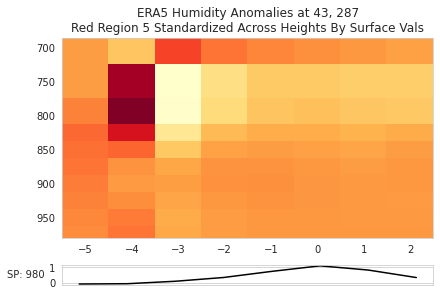

In [96]:
lat, lon = red_coords[4]
df_lb0 = gather_df_anoms(lat,lon)
meshplot(df_lb0,lat,lon,title='\nRed Region 5 Standardized Across Heights By Surface Vals')

In [17]:
dblue_coords = [(41.5, -120.5), (36, -116.5), (37, -101.5), (57.5, -99.5), (50, -92)]

Surface Pressure: 827.711228854487
700.0
750.0
800.0
825.0


,-5,-4,-3,-2,-1,0,1,2
700.000000,-0.005421,0.007784,0.023863,0.052890,0.148274,0.348981,0.541208,0.460521
750.000000,-0.055869,-0.047818,-0.058285,-0.034435,0.034540,0.170706,0.376317,0.390830
800.000000,-0.036036,-0.052296,-0.085488,-0.121966,-0.145645,-0.035748,0.255755,0.317943
825.000000,-0.030784,-0.058353,-0.105573,-0.164406,-0.214135,-0.107116,0.227197,0.300802
827.711229,-0.053139,-0.091406,-0.166248,-0.233952,-0.270714,-0.092943,0.295173,0.377606


-5   -0.053139
-4   -0.091406
-3   -0.166248
-2   -0.233952
-1   -0.270714
 0   -0.092943
 1    0.295173
 2    0.377606
Name: 827.711228854487, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,0.102009,-0.085156,-0.143540,-0.226071,-0.547714,-3.754779,1.833531,1.219582
750.0,1.051381,0.523142,0.350590,0.147188,-0.127589,-1.836669,1.274906,1.035020
800.0,0.678146,0.572133,0.514217,0.521330,0.538003,0.384625,0.866460,0.841996
825.0,0.579311,0.638389,0.635031,0.702735,0.791001,1.152486,0.769709,0.796605


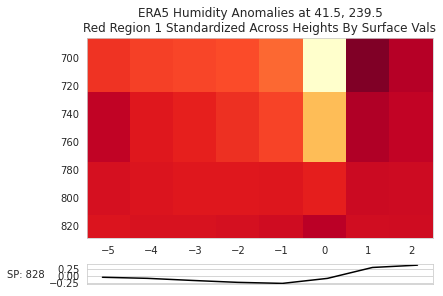

In [98]:
lat, lon = dblue_coords[0]
df_lb0 = gather_df_anoms(lat,lon)
meshplot(df_lb0,lat,lon,title='\nDark blue Region 1 Standardized Across Heights By Surface Vals')

Surface Pressure: 915.9014964767993
700.0
750.0
800.0
825.0
850.0
875.0
900.0


,-5,-4,-3,-2,-1,0,1,2
700.000000,-0.090177,-0.093453,-0.083512,-0.088332,-0.069497,0.018343,0.195425,0.291879
750.000000,-0.082589,-0.068498,0.011877,0.077613,0.141011,0.192522,0.223582,0.268469
800.000000,-0.077022,-0.075062,-0.026281,-0.010209,0.011113,0.057862,0.134677,0.226780
825.000000,-0.077860,-0.081052,-0.060373,-0.085524,-0.094333,-0.040951,0.097867,0.224595
850.000000,-0.085499,-0.091233,-0.084525,-0.125689,-0.142300,-0.080129,0.094718,0.239677
875.000000,-0.091777,-0.102746,-0.109733,-0.163284,-0.184499,-0.106624,0.104791,0.258356
900.000000,-0.095020,-0.109771,-0.126117,-0.183355,-0.206975,-0.115300,0.117779,0.266915
915.901496,-0.095674,-0.113516,-0.132888,-0.186503,-0.213483,-0.123399,0.109210,0.258860


-5   -0.095674
-4   -0.113516
-3   -0.132888
-2   -0.186503
-1   -0.213483
 0   -0.123399
 1    0.109210
 2    0.258860
Name: 915.9014964767993, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,0.942540,0.823254,0.628434,0.473620,0.325537,-0.148651,1.789449,1.127559
750.0,0.863237,0.603423,-0.089375,-0.416147,-0.660524,-1.560167,2.047279,1.037124
800.0,0.805047,0.661241,0.197770,0.054740,-0.052054,-0.468905,1.233197,0.876073
825.0,0.813801,0.714009,0.454315,0.458563,0.441876,0.331862,0.896141,0.867634
850.0,0.893644,0.803697,0.636060,0.673924,0.666564,0.649353,0.867308,0.925898
875.0,0.959272,0.905116,0.825755,0.875499,0.864229,0.864059,0.959539,0.998053
900.0,0.993161,0.967009,0.949043,0.983118,0.969512,0.934367,1.078471,1.031121


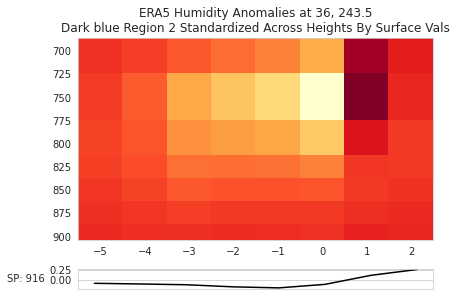

In [101]:
lat, lon = dblue_coords[1]
df_lb0 = gather_df_anoms(lat,lon)
meshplot(df_lb0,lat,lon,title='\nDark blue Region 2 Standardized Across Heights By Surface Vals')

Surface Pressure: 908.2894396494083
700.0
750.0
800.0
825.0
850.0
875.0
900.0


,-5,-4,-3,-2,-1,0,1,2
700.00000,-0.129470,-0.201002,-0.214076,-0.216158,-0.308330,-0.582647,-0.447601,-0.248976
750.00000,-0.065642,-0.061495,-0.064541,-0.050923,-0.039628,-0.063148,0.026217,0.130919
800.00000,-0.128900,-0.138562,-0.115779,-0.150709,-0.220238,-0.408985,-0.236221,-0.008086
825.00000,-0.119079,-0.175861,-0.188529,-0.228498,-0.368281,-0.636731,-0.389287,-0.118974
850.00000,-0.112950,-0.188107,-0.212294,-0.243200,-0.386765,-0.652002,-0.411392,-0.154106
875.00000,-0.115542,-0.192386,-0.213459,-0.243007,-0.375930,-0.636597,-0.415016,-0.182334
900.00000,-0.117245,-0.190488,-0.201688,-0.235340,-0.359396,-0.638768,-0.420003,-0.197014
908.28944,-0.118804,-0.191120,-0.196604,-0.224578,-0.355042,-0.646215,-0.420427,-0.215412


-5   -0.118804
-4   -0.191120
-3   -0.196604
-2   -0.224578
-1   -0.355042
 0   -0.646215
 1   -0.420427
 2   -0.215412
Name: 908.2894396494083, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,1.089776,1.051707,1.088870,0.962507,0.868433,0.901630,1.064635,1.155816
750.0,0.552527,0.321761,0.328278,0.226751,0.111616,0.097720,-0.062358,-0.607764
800.0,1.084981,0.725002,0.588892,0.671077,0.620317,0.632892,0.561860,0.037536
825.0,1.002316,0.920159,0.958925,1.017455,1.037290,0.985323,0.925932,0.552312
850.0,0.950725,0.984237,1.079807,1.082918,1.089351,1.008955,0.978510,0.715401
875.0,0.972543,1.006624,1.085732,1.082060,1.058832,0.985115,0.987131,0.846445
900.0,0.986873,0.996693,1.025859,1.047923,1.012265,0.988476,0.998991,0.914595


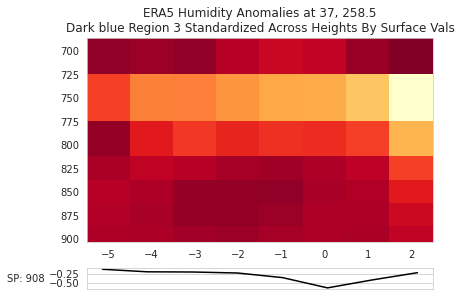

In [102]:
lat, lon = dblue_coords[2]
df_lb0 = gather_df_anoms(lat,lon)
meshplot(df_lb0,lat,lon,title='\nDark blue Region 3 Standardized Across Heights By Surface Vals')

Surface Pressure: 971.4847862287381
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0


,-5,-4,-3,-2,-1,0,1,2
700.000000,0.032646,0.035052,0.101754,0.203690,0.541119,0.964842,0.908220,0.516640
750.000000,0.027162,-0.014559,-0.079581,-0.108356,0.117150,0.527830,0.688649,0.479308
800.000000,0.009775,-0.038038,-0.058146,-0.029855,0.244660,0.650678,0.790943,0.540305
825.000000,0.050853,-0.003712,0.020354,0.085825,0.400382,0.805403,0.910103,0.623973
850.000000,0.076798,0.032111,0.058463,0.131063,0.432997,0.840008,0.937526,0.650168
875.000000,0.092851,0.047296,0.083370,0.141725,0.429545,0.829486,0.933586,0.654218
900.000000,0.078744,0.042651,0.091021,0.141432,0.419279,0.818058,0.924438,0.644252
925.000000,0.041121,0.030741,0.083524,0.135167,0.421048,0.828508,0.918482,0.620452
950.000000,0.008966,0.011668,0.064558,0.121482,0.423459,0.856274,0.917559,0.597795
971.484786,-0.002254,-0.007416,0.046797,0.125265,0.444394,0.896228,0.938593,0.580794


-5   -0.002254
-4   -0.007416
-3    0.046797
-2    0.125265
-1    0.444394
 0    0.896228
 1    0.938593
 2    0.580794
Name: 971.4847862287381, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,-14.484824,-4.726327,2.174374,1.626077,1.217655,1.076559,0.967640,0.889541
750.0,-12.051813,1.963154,-1.700564,-0.865014,0.263618,0.588947,0.733704,0.825264
800.0,-4.337218,5.128948,-1.242515,-0.238334,0.550547,0.726018,0.842690,0.930287
825.0,-22.563237,0.500488,0.434954,0.685147,0.900961,0.898659,0.969647,1.074346
850.0,-34.075157,-4.329724,1.249282,1.046287,0.974354,0.937271,0.998864,1.119447
875.0,-41.197685,-6.377347,1.781529,1.131401,0.966585,0.925531,0.994666,1.126420
900.0,-34.938507,-5.751000,1.945019,1.129064,0.943484,0.912779,0.984920,1.109261
925.0,-18.245115,-4.145047,1.784817,1.079055,0.947465,0.924439,0.978574,1.068282
950.0,-3.978335,-1.573348,1.379538,0.969801,0.952891,0.955420,0.977591,1.029272


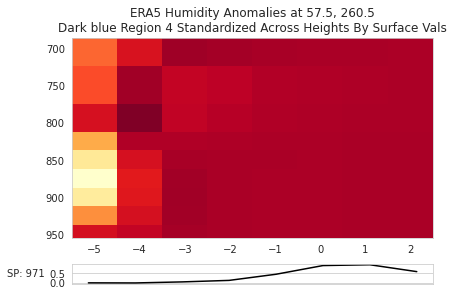

In [103]:
lat, lon = dblue_coords[3]
df_lb0 = gather_df_anoms(lat,lon)
meshplot(df_lb0,lat,lon,title='\nDark blue Region 4 Standardized Across Heights By Surface Vals')

Surface Pressure: 968.5015023951091
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0


,-5,-4,-3,-2,-1,0,1,2
700.000000,0.144485,0.204098,0.300467,0.533997,0.892787,1.337401,1.052730,0.581598
750.000000,-0.078401,-0.088123,-0.083510,0.028308,0.231369,0.615409,0.530843,0.265008
800.000000,-0.087086,-0.053025,-0.048323,0.089318,0.265706,0.670552,0.600521,0.299788
825.000000,-0.068030,-0.006468,0.027825,0.194295,0.400574,0.834004,0.732489,0.374724
850.000000,-0.049686,0.023937,0.062815,0.246927,0.486117,0.933327,0.796023,0.418869
875.000000,-0.004097,0.058515,0.107893,0.307703,0.570544,1.018238,0.849556,0.461675
900.000000,0.039871,0.087355,0.141592,0.351522,0.627102,1.073122,0.873425,0.464960
925.000000,0.054628,0.092762,0.146320,0.355583,0.638063,1.101937,0.888104,0.465614
950.000000,0.049834,0.080598,0.133747,0.341371,0.626833,1.113848,0.910613,0.482686
968.501502,0.051360,0.077485,0.132962,0.333288,0.627517,1.121127,0.942398,0.507046


-5    0.051360
-4    0.077485
-3    0.132962
-2    0.333288
-1    0.627517
 0    1.121127
 1    0.942398
 2    0.507046
Name: 968.5015023951091, dtype: float64

,-5,-4,-3,-2,-1,0,1,2
700.0,2.813184,2.634013,2.259797,1.602210,1.422729,1.192908,1.117076,1.147032
750.0,-1.526505,-1.137281,-0.628076,0.084935,0.368705,0.548920,0.563289,0.522650
800.0,-1.695597,-0.684324,-0.363435,0.267989,0.423424,0.598106,0.637226,0.591244
825.0,-1.324575,-0.083475,0.209272,0.582964,0.638347,0.743898,0.777261,0.739034
850.0,-0.967412,0.308919,0.472429,0.740881,0.774667,0.832490,0.844678,0.826096
875.0,-0.079767,0.755176,0.811463,0.923236,0.909209,0.908227,0.901483,0.910519
900.0,0.776315,1.127374,1.064905,1.054708,0.999339,0.957181,0.926811,0.916998
925.0,1.063625,1.197153,1.100466,1.066894,1.016805,0.982883,0.942387,0.918288
950.0,0.970283,1.040167,1.005906,1.024253,0.998909,0.993507,0.966272,0.951958


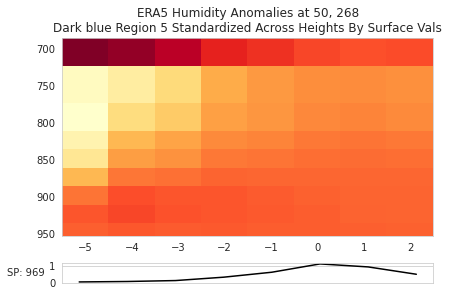

In [104]:
lat, lon = dblue_coords[4]
df_lb0 = gather_df_anoms(lat,lon)
meshplot(df_lb0,lat,lon,title='\nDark blue Region 5 Standardized Across Heights By Surface Vals')

In [10]:
wcr = xr.open_dataset("/home/dhruv/fluxnet/US-WCr.nc")
srm = xr.open_dataset("/home/dhruv/fluxnet/US-SRM.nc")
obs = xr.open_dataset("/home/dhruv/fluxnet/CA-Obs.nc")

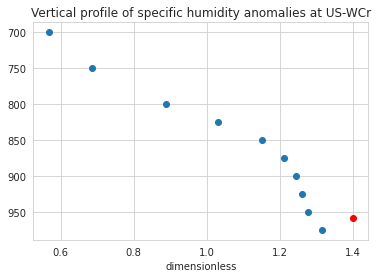

In [11]:
humidity_profile(wcr.lat.item(), wcr.lon.item(), "Vertical profile of specific humidity anomalies at US-WCr")

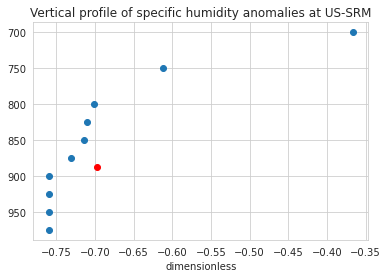

In [12]:
humidity_profile(srm.lat.item(), srm.lon.item(), "Vertical profile of specific humidity anomalies at US-SRM")

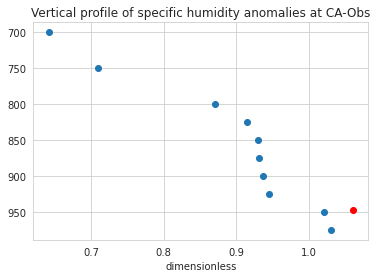

In [13]:
humidity_profile(obs.lat.item(), obs.lon.item(), "Vertical profile of specific humidity anomalies at CA-Obs")

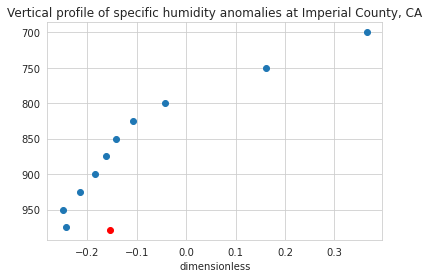

In [14]:
humidity_profile(33.384, -115.097, "Vertical profile of specific humidity anomalies at Imperial County, CA")

In [10]:
def pre_humidity_profile(lat, lon, name=""):
    if lon < 0:
        lon = lon + 360
    
    t2m_data = t2m.t2m.sel(dict(lat=lat, lon=lon), method='nearest')
    t2m_anoms = remove_annual_cycle(jja_std_anoms(t2m_data))
    jja_t2m_anoms = t2m_anoms.sel(time=t2m_anoms['time.season']=='JJA')
    heatwave_days = jja_t2m_anoms[jja_t2m_anoms>=jja_t2m_anoms.quantile(0.90)].time.values
    pre_hw_days = [day+pd.Timedelta(days=-5) for day in heatwave_days]

    surface_pressure = ps.ps.sel(dict(lat=lat, lon=lon), method='nearest').mean().compute().item()/100.
    
    td2m_data = td2m.td2m.sel(dict(lat=lat, lon=lon), method='nearest').load()
    surface_humidity = mpcalc.specific_humidity_from_dewpoint(surface_pressure*units.hPa, 
                                                          td2m_data*units.K)
    humidity_anoms = remove_annual_cycle(jja_std_anoms(surface_humidity))
    hw_humidity = humidity_anoms.sel(time=pre_hw_days).mean().item()

    vert_profile = dict()
    for level in levels:
        if level > surface_pressure:
            break
        q_level = q.sel(level=level).sel(dict(lat=lat, lon=lon), method='nearest').load()
        q_level_anoms = remove_annual_cycle(jja_std_anoms(q_level.Q))
        vert_profile[level] = q_level_anoms.sel(time=pre_hw_days).mean().item()
        
    plt.scatter(hw_humidity, surface_pressure, color='r')
    plt.scatter(vert_profile.values(), vert_profile.keys())
    plt.gca().invert_yaxis()
    plt.title("Vertical profile of humidity anomalies 5 days before heatwave at"
              "\n {}; lat: {}, lon: {}".format(name, lat, lon))    
    plt.show()

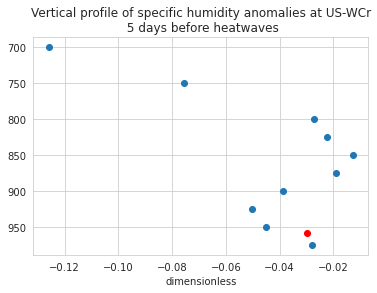

In [16]:
pre_humidity_profile(wcr.lat.item(), wcr.lon.item(), "Vertical profile of specific humidity anomalies at US-WCr")

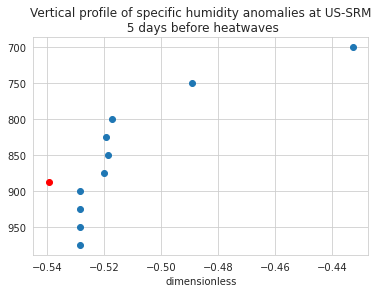

In [17]:
pre_humidity_profile(srm.lat.item(), srm.lon.item(), "Vertical profile of specific humidity anomalies at US-SRM")

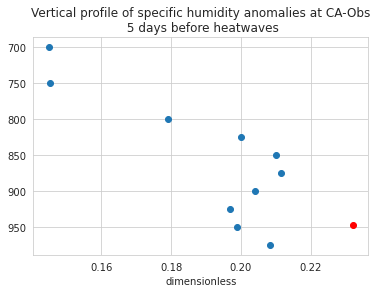

In [18]:
pre_humidity_profile(obs.lat.item(), obs.lon.item(), "Vertical profile of specific humidity anomalies at CA-Obs")

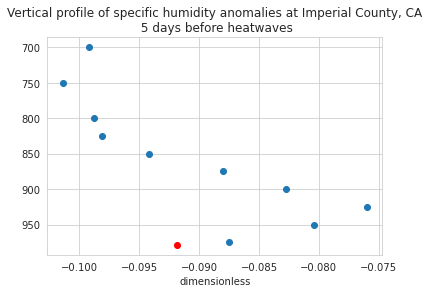

In [19]:
pre_humidity_profile(33.384, -115.097, "Vertical profile of specific humidity anomalies at Imperial County, CA")

In [11]:
def anoms(data):
    data = data.sel(time=~((data.time.dt.month==2) & (data.time.dt.day == 29)))
    daystr = xr.DataArray(data.indexes['time'].strftime('%m-%d'), coords = data.time.coords, name="daystr")
    datseason = data.groupby(daystr).mean('time')
    harmonics = filt.calc_season_nharm(datseason, 4, dimtime=0)
    anoms = data.groupby(daystr)-harmonics
    return anoms

In [12]:
def non_std_humidity_profile(lat, lon, name=""):
    if lon < 0:
        lon = lon + 360
    
    t2m_data = t2m.t2m.sel(dict(lat=lat, lon=lon), method='nearest')
    t2m_anoms = remove_annual_cycle(jja_std_anoms(t2m_data))
    jja_t2m_anoms = t2m_anoms.sel(time=t2m_anoms['time.season']=='JJA')
    heatwave_days = jja_t2m_anoms[jja_t2m_anoms>=jja_t2m_anoms.quantile(0.90)].time.values
    
    
    surface_pressure = ps.ps.sel(dict(lat=lat, lon=lon), method='nearest').mean().compute().item()/100.
    
    td2m_data = td2m.td2m.sel(dict(lat=lat, lon=lon), method='nearest').load()
    surface_humidity = mpcalc.specific_humidity_from_dewpoint(surface_pressure*units.hPa, 
                                                          td2m_data*units.K)
    humidity_anoms = remove_annual_cycle(anoms(surface_humidity))
    hw_humidity = humidity_anoms.sel(time=heatwave_days).mean().item()

    vert_profile = dict()
    for level in levels:
        if level > surface_pressure:
            break
        q_level = q.sel(level=level).sel(dict(lat=lat, lon=lon), method='nearest').load()
        q_level_anoms = remove_annual_cycle(anoms(q_level.Q))
        vert_profile[level] = q_level_anoms.sel(time=heatwave_days).mean().item()
        
    plt.scatter(hw_humidity, surface_pressure, color='g')
    plt.scatter(vert_profile.values(), vert_profile.keys(), color='purple')
    plt.gca().invert_yaxis()
    plt.title("Vertical profile of humidity anomalies during heatwave days at"
              "\n {}; lat: {}, lon: {}".format(name, lat, lon))
    plt.show()

In [13]:
def non_std_pre_hw_humidity_profile(lat, lon, name=""):
    if lon < 0:
        lon = lon + 360
    
    t2m_data = t2m.t2m.sel(dict(lat=lat, lon=lon), method='nearest')
    t2m_anoms = remove_annual_cycle(jja_std_anoms(t2m_data))
    jja_t2m_anoms = t2m_anoms.sel(time=t2m_anoms['time.season']=='JJA')
    heatwave_days = jja_t2m_anoms[jja_t2m_anoms>=jja_t2m_anoms.quantile(0.90)].time.values
    pre_hw_days = [day+pd.Timedelta(days=-5) for day in heatwave_days]

    surface_pressure = ps.ps.sel(dict(lat=lat, lon=lon), method='nearest').mean().compute().item()/100.
    
    td2m_data = td2m.td2m.sel(dict(lat=lat, lon=lon), method='nearest').load()
    surface_humidity = mpcalc.specific_humidity_from_dewpoint(surface_pressure*units.hPa, 
                                                          td2m_data*units.K)
    humidity_anoms = remove_annual_cycle(anoms(surface_humidity))
    hw_humidity = humidity_anoms.sel(time=pre_hw_days).mean().item()

    vert_profile = dict()
    for level in levels:
        if level > surface_pressure:
            break
        q_level = q.sel(level=level).sel(dict(lat=lat, lon=lon), method='nearest').load()
        q_level_anoms = remove_annual_cycle(anoms(q_level.Q))
        vert_profile[level] = q_level_anoms.sel(time=pre_hw_days).mean().item()
        
    plt.scatter(hw_humidity, surface_pressure, color='g')
    plt.scatter(vert_profile.values(), vert_profile.keys(), color='purple')
    plt.gca().invert_yaxis()
    plt.title("Vertical profile of humidity anomalies 5 days before heatwaves at"
              "\n {}; lat: {}, lon: {}".format(name, lat, lon))
    plt.show()

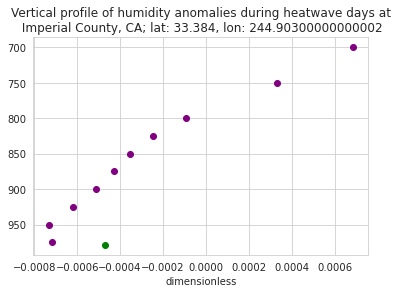

In [17]:
non_std_humidity_profile(33.384, -115.097, "Imperial County, CA")

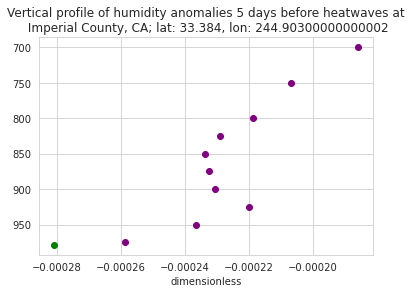

In [16]:
non_std_pre_hw_humidity_profile(33.384, -115.097, "Imperial County, CA")

In [12]:
outdir="/home/dhruv/fluxnet/"
stations = glob(outdir+"*.nc")
NH_stations = []

for i in stations:
    temp = xr.open_dataset(i)
    lat, lon = temp.lat.item(), temp.lon.item()
    if (lon > -135 and lon < -60) and (lat > 23 and lat < 70):
        NH_stations.append(i)
        print(i)

/home/dhruv/fluxnet/US-WCr.nc
/home/dhruv/fluxnet/US-Var.nc
/home/dhruv/fluxnet/US-UMB.nc
/home/dhruv/fluxnet/US-Ha1.nc
/home/dhruv/fluxnet/US-Ne3.nc
/home/dhruv/fluxnet/US-GLE.nc
/home/dhruv/fluxnet/US-Blo.nc
/home/dhruv/fluxnet/CA-Man.nc
/home/dhruv/fluxnet/US-NR1.nc
/home/dhruv/fluxnet/US-SRM.nc
/home/dhruv/fluxnet/US-Syv.nc
/home/dhruv/fluxnet/CA-Oas.nc
/home/dhruv/fluxnet/CA-Gro.nc
/home/dhruv/fluxnet/CA-TP4.nc
/home/dhruv/fluxnet/CA-TP1.nc
/home/dhruv/fluxnet/US-Me2.nc
/home/dhruv/fluxnet/US-Oho.nc
/home/dhruv/fluxnet/US-Los.nc
/home/dhruv/fluxnet/CA-Obs.nc
/home/dhruv/fluxnet/US-MMS.nc
/home/dhruv/fluxnet/US-Ne2.nc
/home/dhruv/fluxnet/US-Wkg.nc
/home/dhruv/fluxnet/US-ARM.nc
/home/dhruv/fluxnet/CA-TP3.nc
/home/dhruv/fluxnet/US-Ton.nc


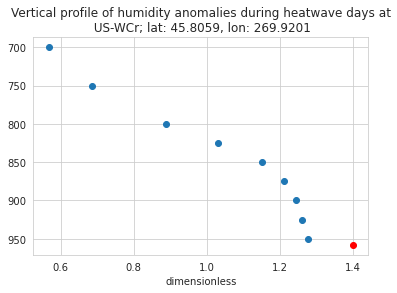

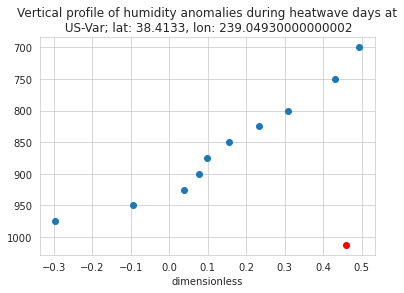

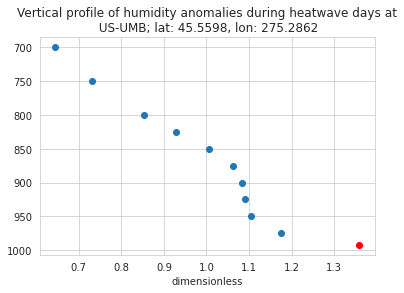

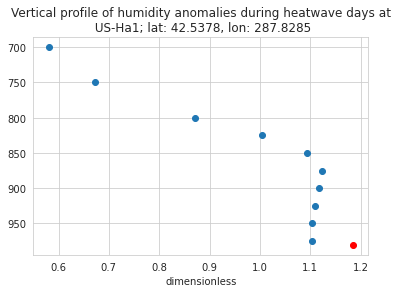

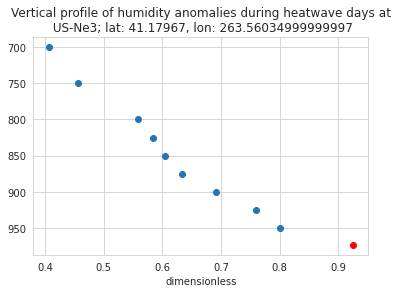

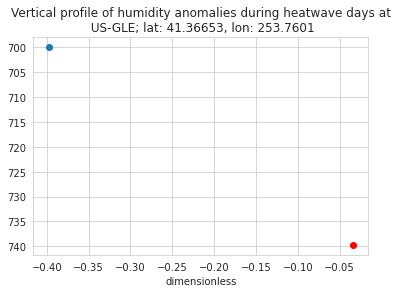

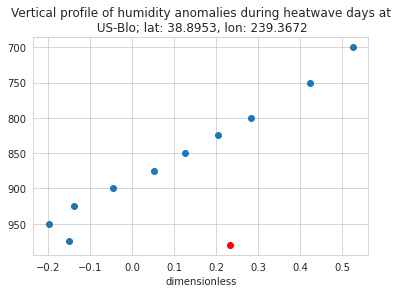

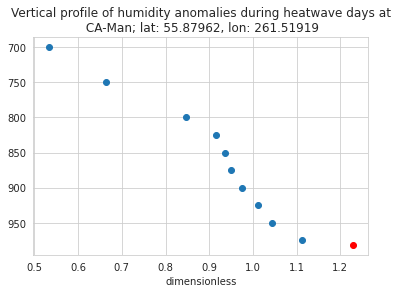

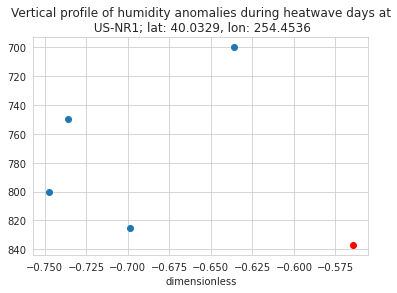

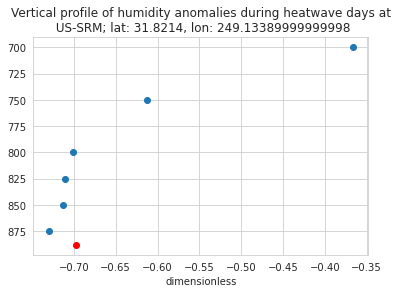

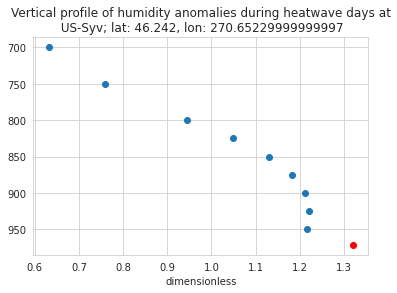

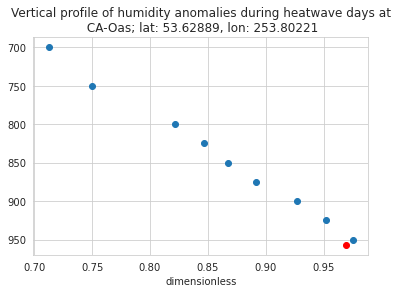

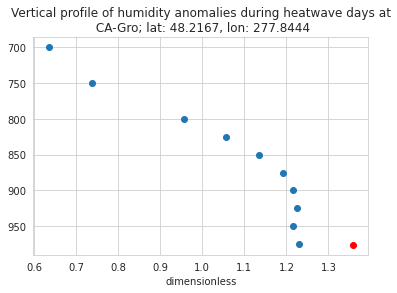

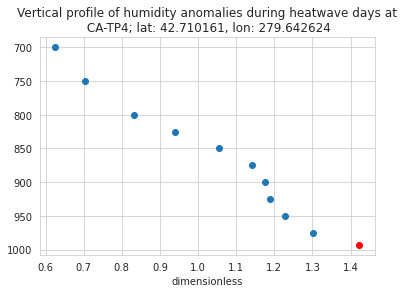

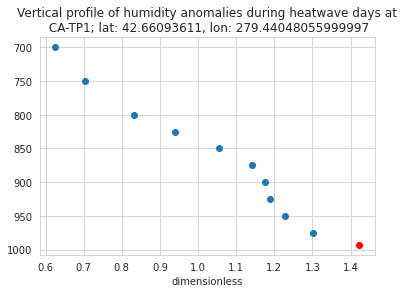

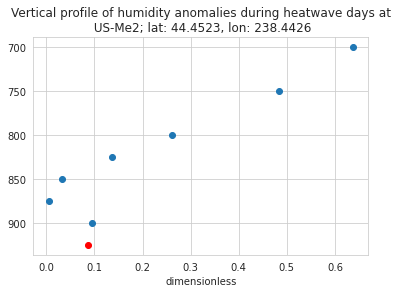

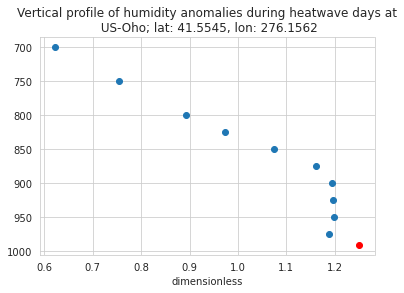

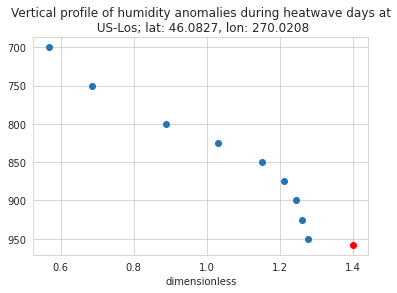

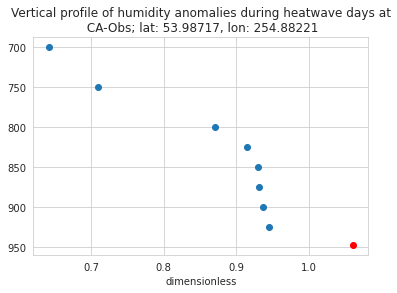

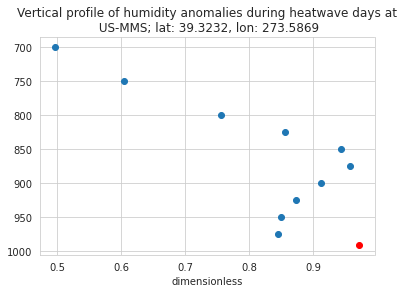

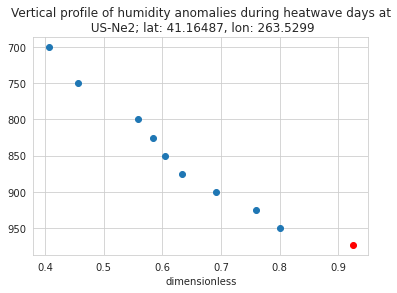

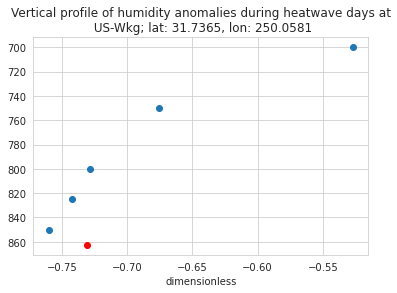

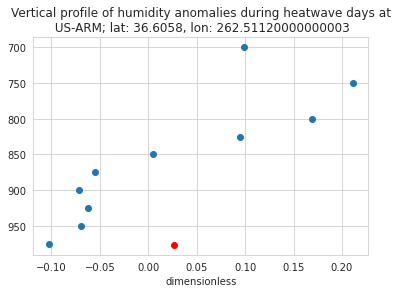

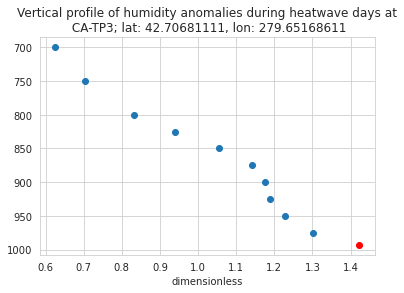

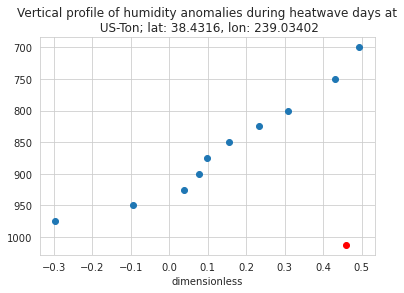

In [18]:
for i in NH_stations:
    name = i[-9:-3]
    ds = xr.open_dataset(i)
    humidity_profile(ds.lat.item(), ds.lon.item(), name)

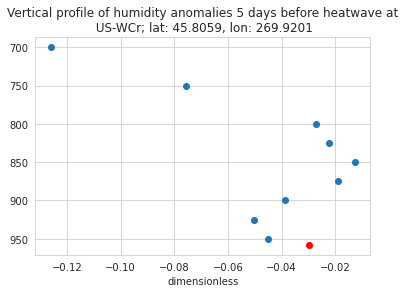

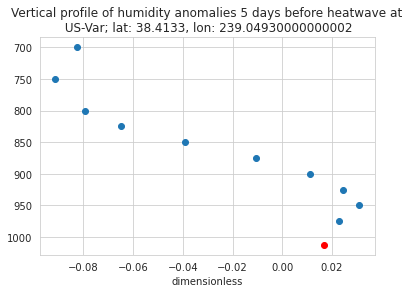

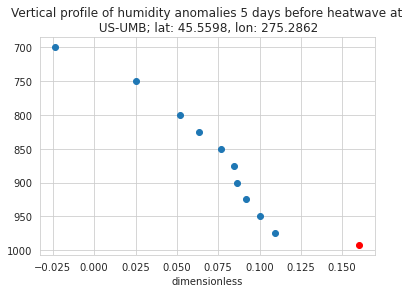

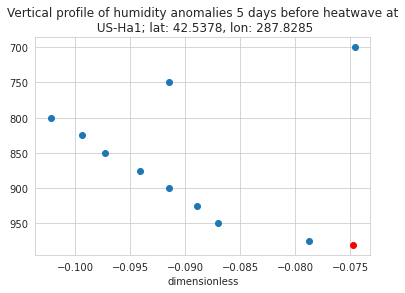

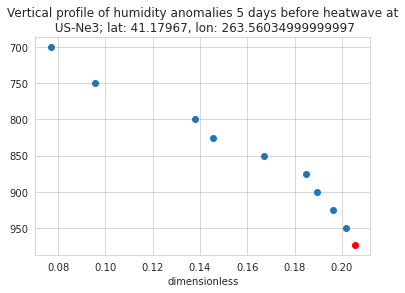

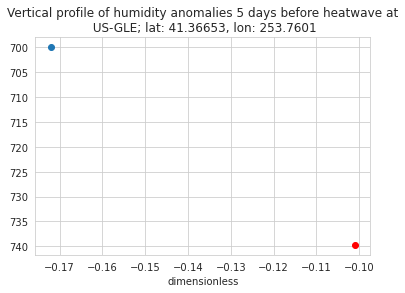

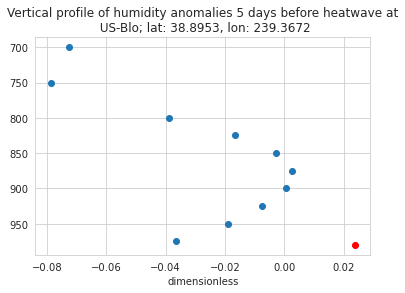

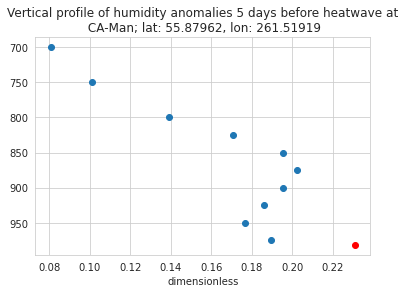

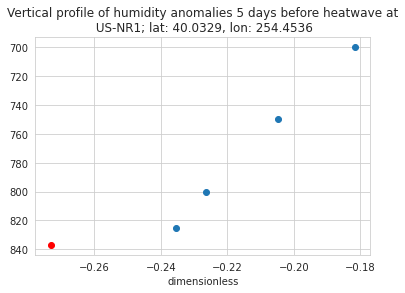

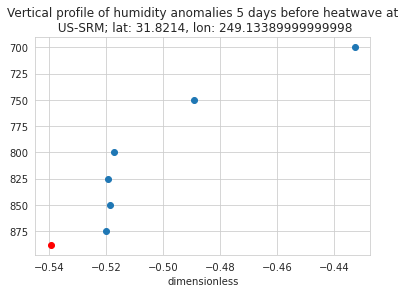

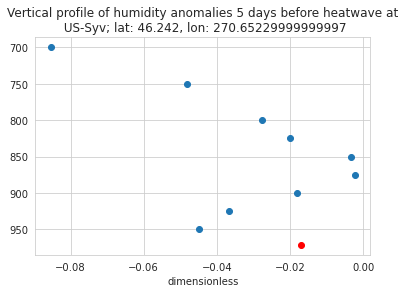

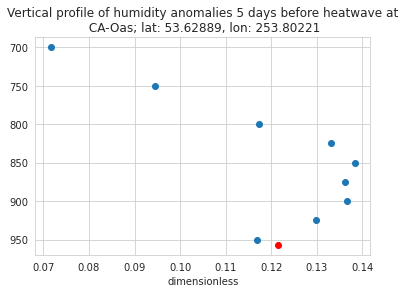

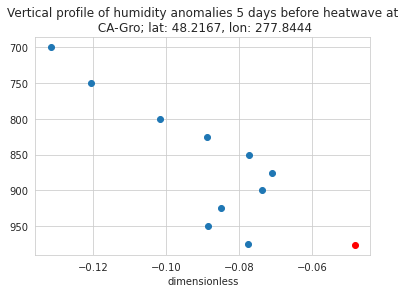

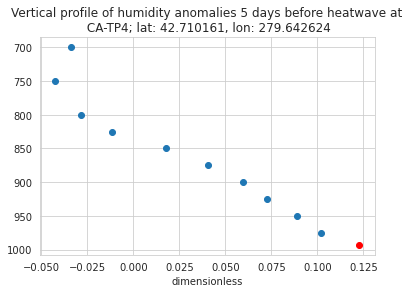

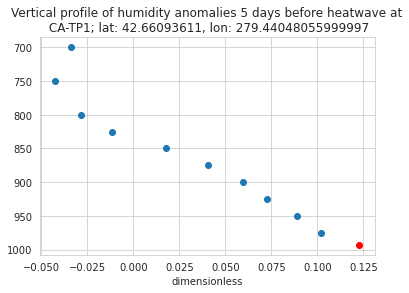

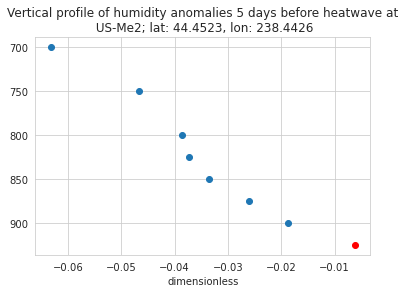

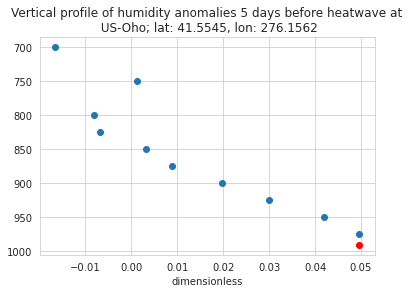

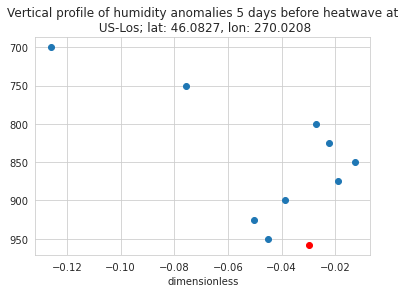

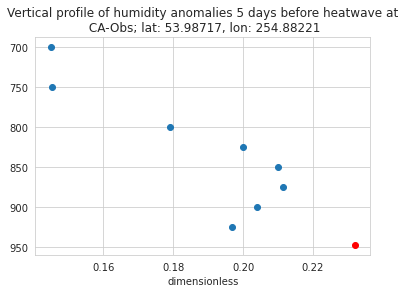

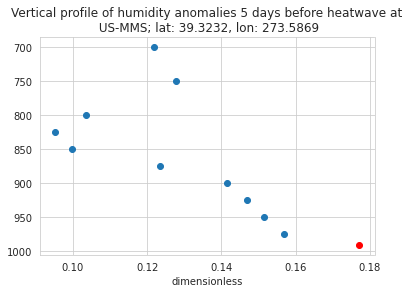

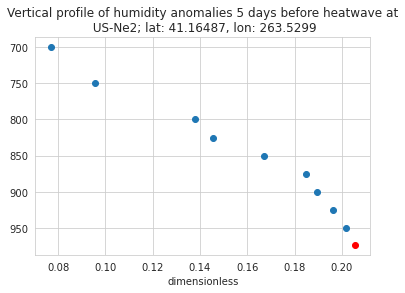

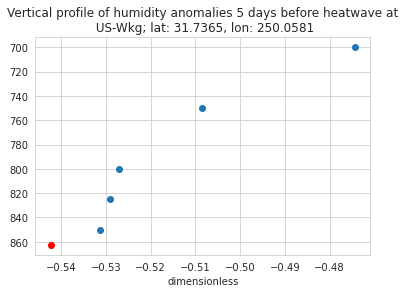

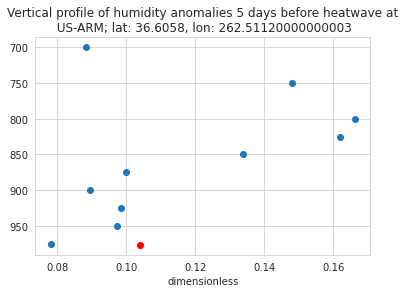

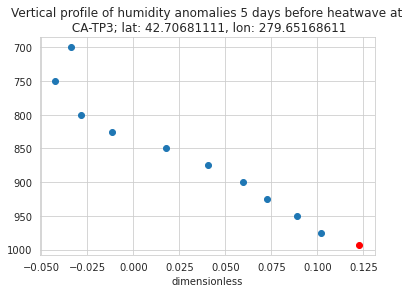

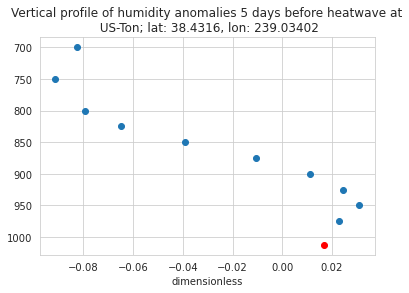

In [19]:
for i in NH_stations:
    name = i[-9:-3]
    ds = xr.open_dataset(i)
    pre_humidity_profile(ds.lat.item(), ds.lon.item(), name)

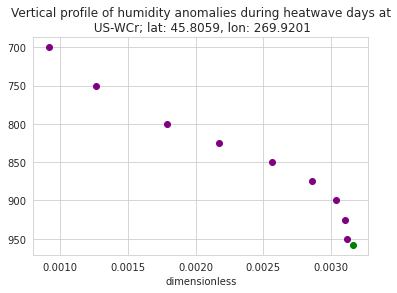

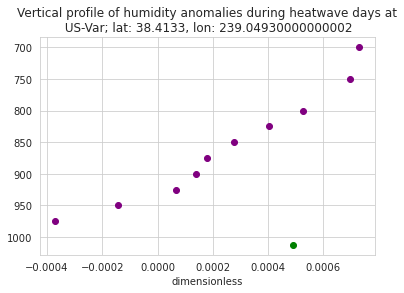

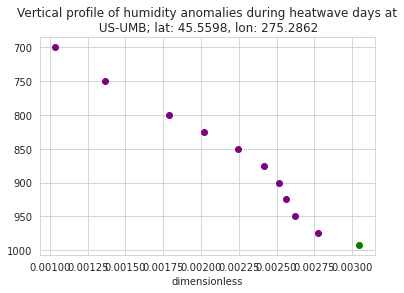

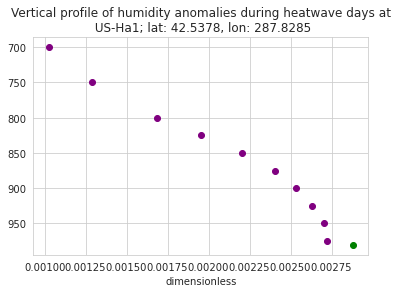

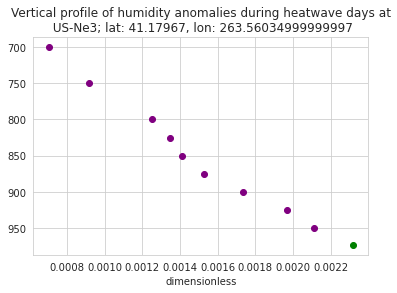

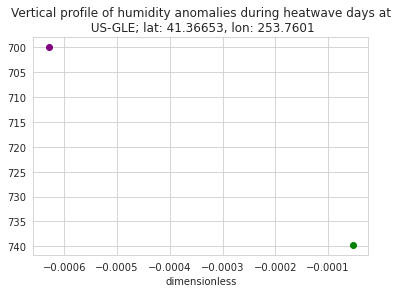

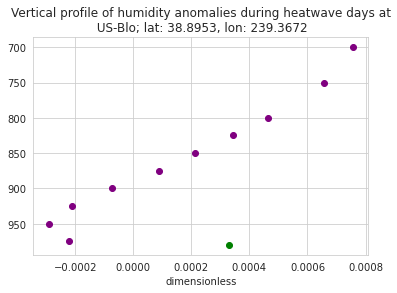

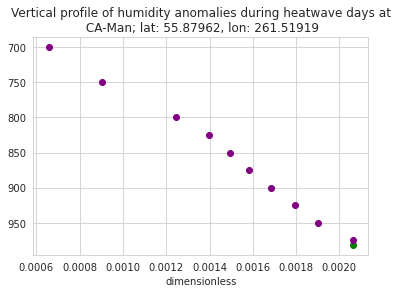

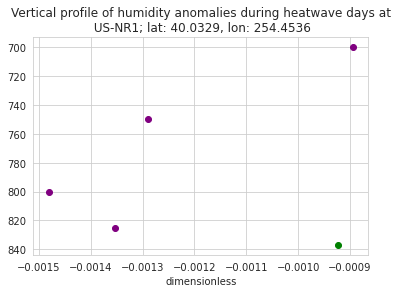

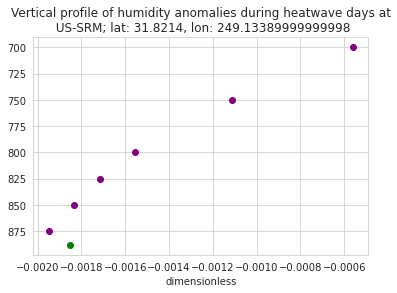

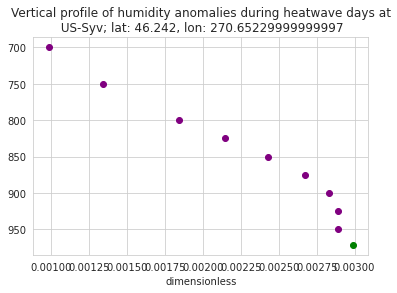

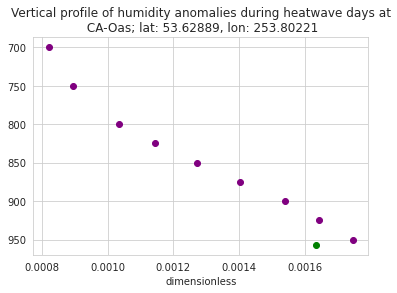

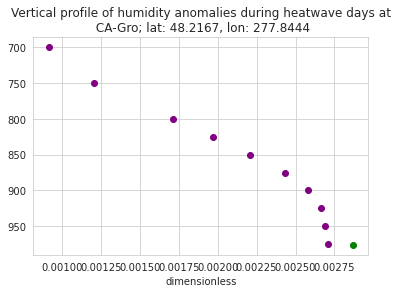

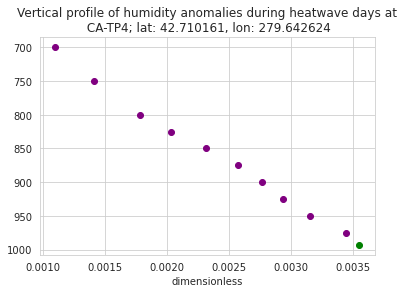

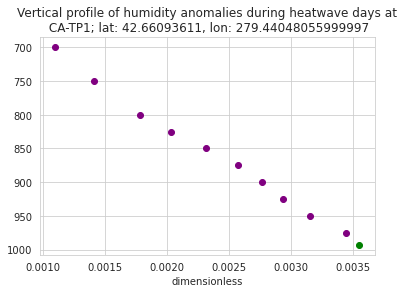

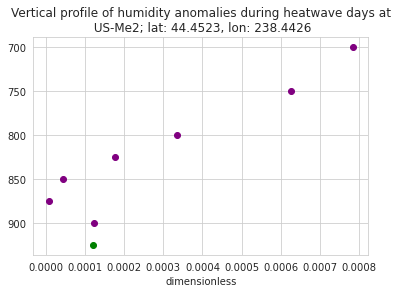

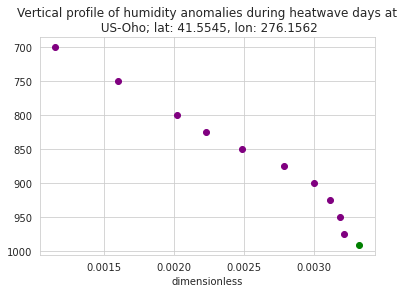

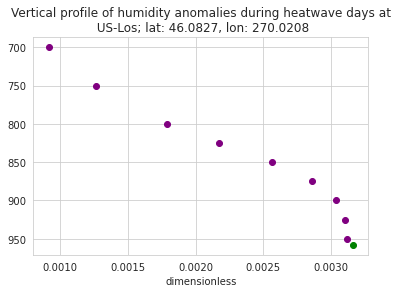

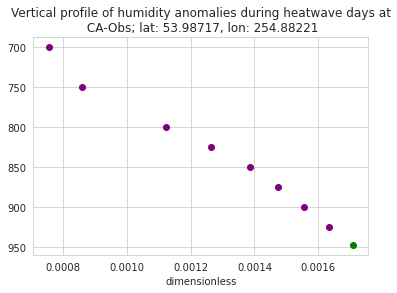

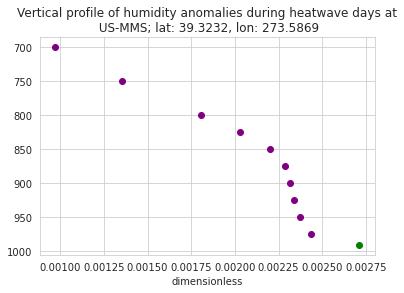

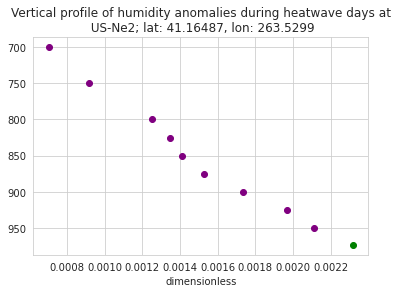

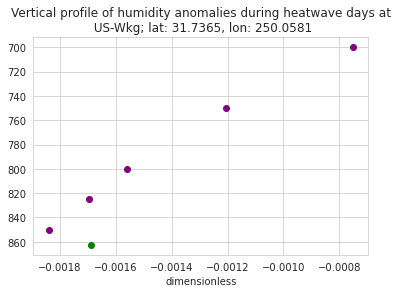

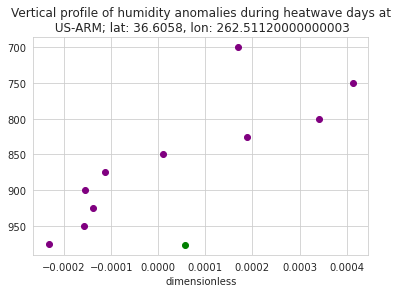

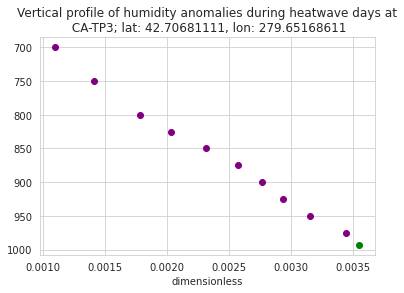

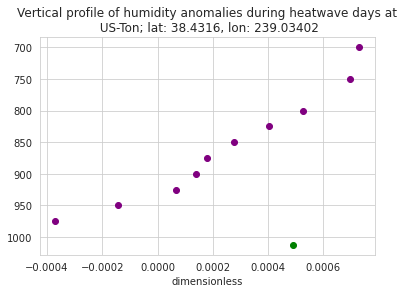

In [14]:
for i in NH_stations:
    name = i[-9:-3]
    ds = xr.open_dataset(i)
    non_std_humidity_profile(ds.lat.item(), ds.lon.item(), name)

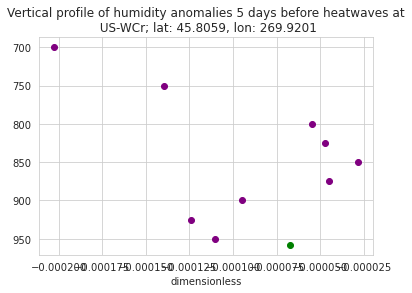

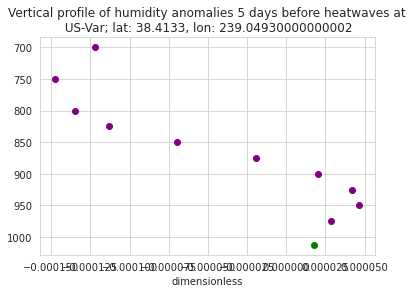

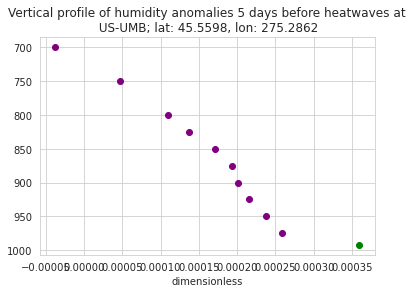

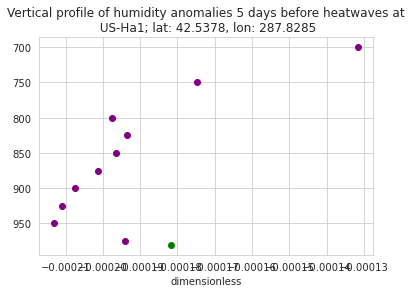

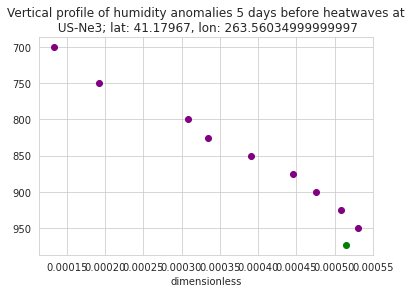

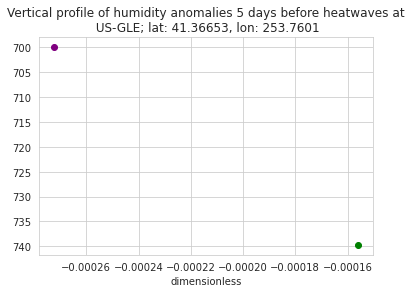

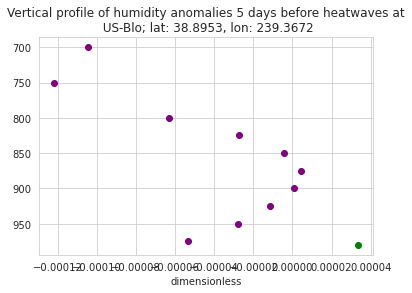

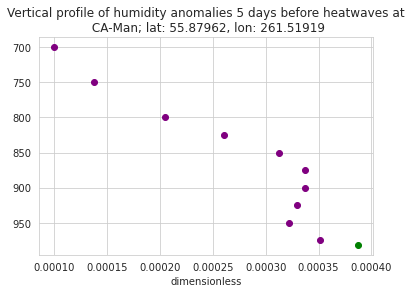

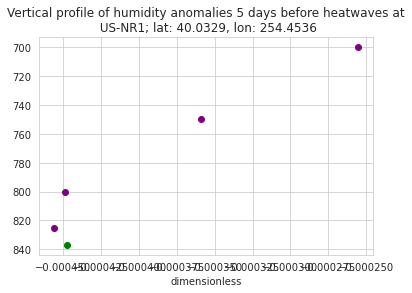

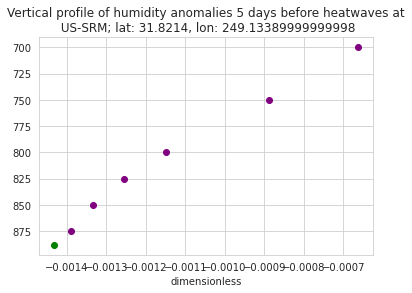

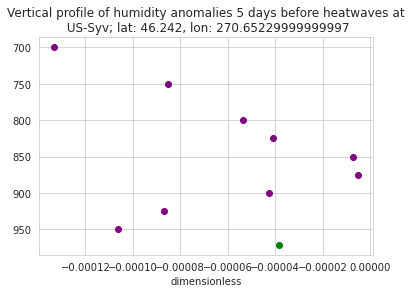

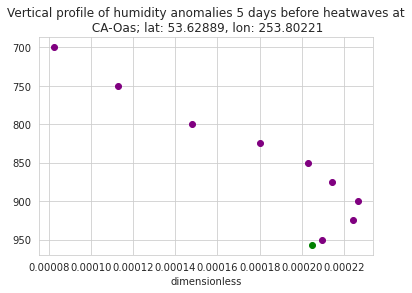

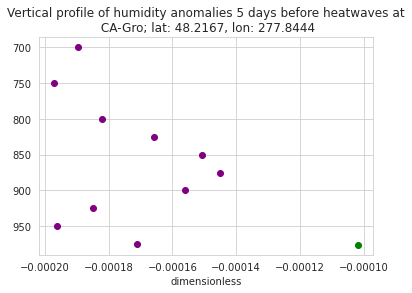

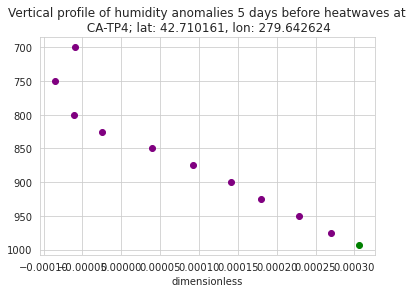

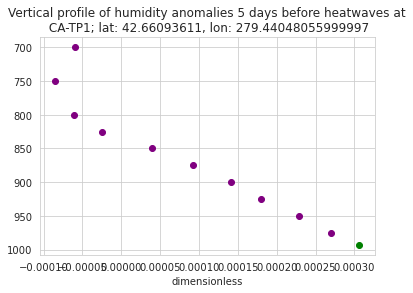

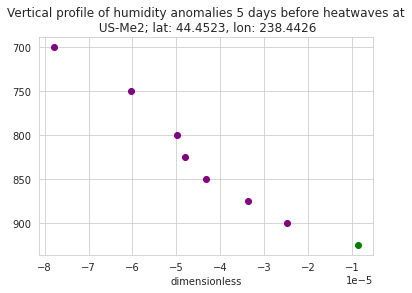

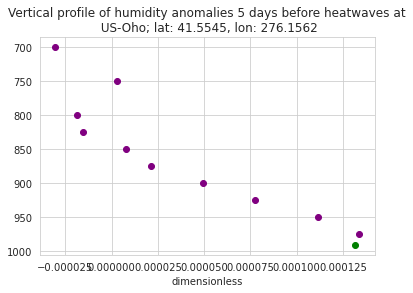

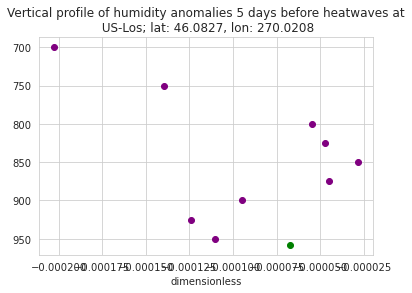

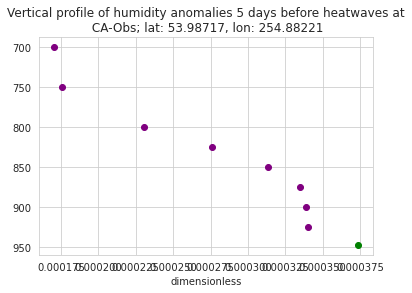

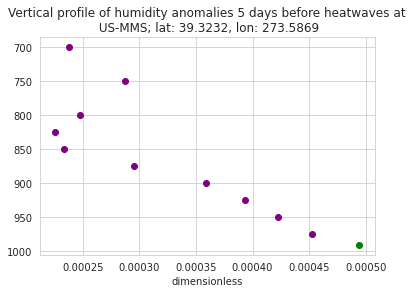

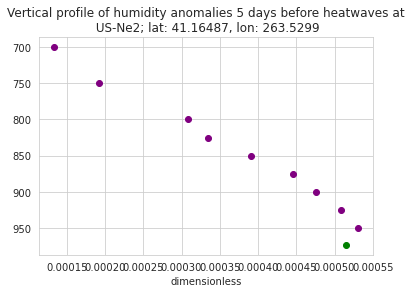

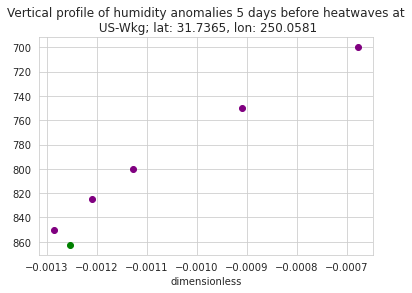

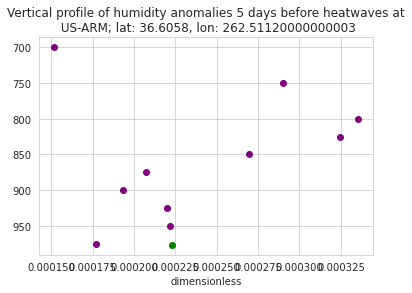

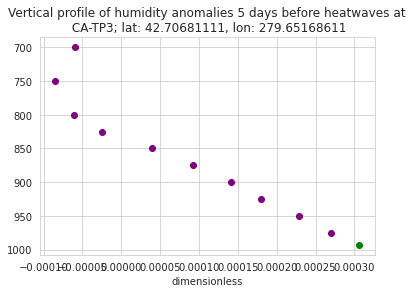

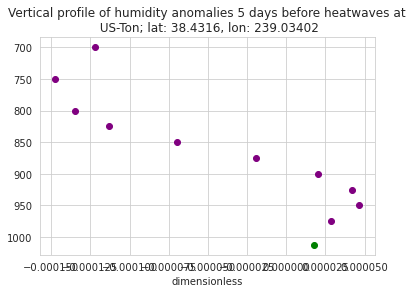

In [15]:
for i in NH_stations:
    name = i[-9:-3]
    ds = xr.open_dataset(i)
    non_std_pre_hw_humidity_profile(ds.lat.item(), ds.lon.item(), name)

Checking humidity profile in FL to see how Southeast and Southwest are both in the salmon regime yet different

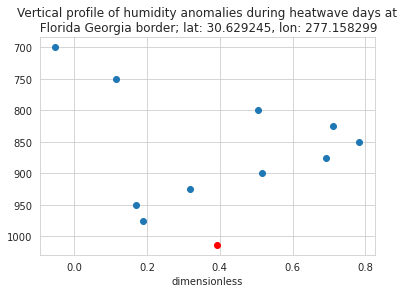

In [14]:
humidity_profile(30.629245, -82.841701, "Florida Georgia border")

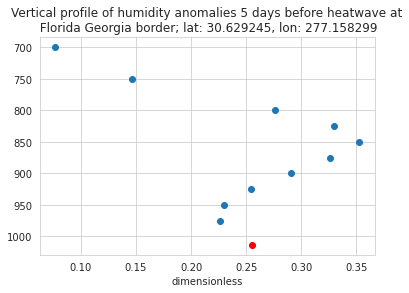

In [15]:
pre_humidity_profile(30.629245, -82.841701, "Florida Georgia border")

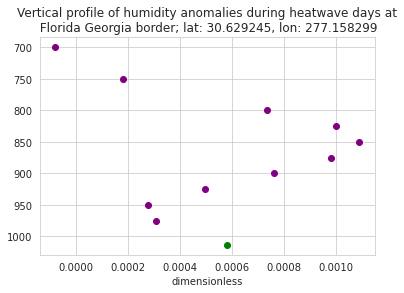

In [16]:
non_std_humidity_profile(30.629245, -82.841701, "Florida Georgia border")

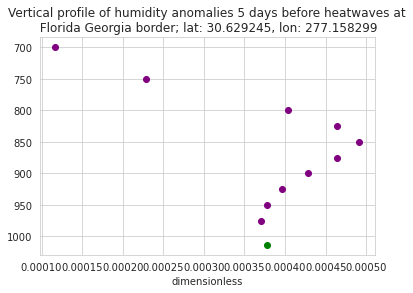

In [17]:
non_std_pre_hw_humidity_profile(30.629245, -82.841701, "Florida Georgia border")

In [18]:
coords = {'light blue': lblue_coords, 'dark blue': dblue_coords, 
          'salmon': pink_coords, 'red': red_coords}

Surface Pressure: 838.5219763443237
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.104515,0.108517,0.127144,0.256680,0.479591,0.699397,0.758035,0.568773
750.0,0.065438,0.040410,-0.019398,-0.009616,0.079488,0.353880,0.506965,0.451871
800.0,0.053378,0.042551,-0.005823,-0.029220,-0.040599,0.165995,0.396877,0.408004
825.0,0.042087,0.037846,-0.012049,-0.071985,-0.116682,0.065090,0.380679,0.425113
850.0,0.033002,0.029008,-0.010409,-0.061881,-0.082885,0.084907,0.397080,0.431654
875.0,0.032260,0.022308,0.003526,0.031361,0.148554,0.350357,0.555461,0.489347
900.0,0.051478,0.048728,0.048217,0.109344,0.246755,0.412481,0.578505,0.491947
925.0,0.051478,0.048729,0.048219,0.109345,0.246754,0.412480,0.578504,0.491947
950.0,0.051478,0.048729,0.048217,0.109345,0.246755,0.412481,0.578505,0.491946
975.0,0.051479,0.048728,0.048217,0.109344,0.246754,0.412481,0.578505,0.491946


-5    0.051479
-4    0.048729
-3    0.048218
-2    0.109345
-1    0.246754
 0    0.412481
 1    0.578505
 2    0.491946
Name: 1020.0, dtype: float64

Surface Pressure: 942.3197206518937
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.210800,0.233022,0.289833,0.468983,0.867109,1.334226,0.910286,0.400785
750.0,-0.012513,0.059442,0.069381,0.053580,0.305392,0.669874,0.494019,0.221357
800.0,0.032176,0.105430,0.138328,0.116127,0.343364,0.716744,0.547478,0.281971
825.0,0.118484,0.166245,0.200489,0.232595,0.433984,0.816814,0.608573,0.324632
850.0,0.143469,0.188098,0.225975,0.291054,0.520124,0.914564,0.644521,0.325398
875.0,0.153775,0.186656,0.226325,0.321762,0.601381,1.025480,0.684702,0.311568
900.0,0.157225,0.176094,0.210954,0.330995,0.658990,1.098569,0.722908,0.306691
925.0,0.164039,0.171932,0.195031,0.325809,0.686067,1.150535,0.776630,0.324457
950.0,0.172611,0.172571,0.195470,0.337553,0.707433,1.204500,0.853240,0.359066
975.0,0.190230,0.208296,0.250526,0.416482,0.799140,1.273690,0.909778,0.390695


-5    0.196648
-4    0.216715
-3    0.259288
-2    0.429114
-1    0.807460
 0    1.276199
 1    0.908769
 2    0.389573
Name: 1020.0, dtype: float64

Surface Pressure: 955.9903703100056
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.120271,0.213126,0.292371,0.425319,0.739975,0.881779,0.655187,0.315501
750.0,0.068207,0.081713,0.020948,0.057292,0.166009,0.366634,0.569845,0.367042
800.0,0.056719,0.126436,0.037926,0.100242,0.233762,0.435840,0.587258,0.382379
825.0,0.082509,0.159046,0.096440,0.118006,0.289753,0.477162,0.529421,0.309712
850.0,0.091292,0.163226,0.136411,0.139229,0.348526,0.483763,0.507230,0.281204
875.0,0.091121,0.156095,0.158324,0.173672,0.417373,0.506506,0.492695,0.269427
900.0,0.105639,0.165470,0.175504,0.229029,0.500021,0.562629,0.499130,0.269137
925.0,0.117987,0.184880,0.209092,0.284581,0.574451,0.661852,0.545176,0.293005
950.0,0.122532,0.200259,0.241794,0.327754,0.624862,0.741665,0.604492,0.317400
975.0,0.123745,0.202862,0.262480,0.365101,0.662974,0.789448,0.652937,0.333508


-5    0.132471
-4    0.214318
-3    0.276257
-2    0.385722
-1    0.673898
 0    0.783397
 1    0.653825
 2    0.342729
Name: 1020.0, dtype: float64

Surface Pressure: 981.6633820106065
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.063061,0.150974,0.313197,0.584807,1.016211,1.362692,0.951202,0.450905
750.0,0.030198,0.027295,0.133160,0.258852,0.475831,0.583170,0.484391,0.278947
800.0,0.041101,0.040644,0.107570,0.248431,0.507973,0.665058,0.522299,0.266396
825.0,0.078551,0.093986,0.134428,0.257865,0.558856,0.762668,0.561253,0.259746
850.0,0.075586,0.124550,0.181416,0.309540,0.627592,0.857348,0.629685,0.296638
875.0,0.079737,0.143304,0.214974,0.382919,0.723678,0.989212,0.719919,0.348607
900.0,0.062722,0.136513,0.236701,0.453723,0.816391,1.101763,0.788404,0.389213
925.0,0.054390,0.124446,0.249765,0.483296,0.870784,1.168070,0.821956,0.399848
950.0,0.046467,0.116126,0.249807,0.486805,0.892610,1.211365,0.858324,0.406043
975.0,0.037724,0.107994,0.249600,0.490745,0.899337,1.236590,0.895903,0.420428


-5    0.040351
-4    0.108852
-3    0.253871
-2    0.508697
-1    0.907483
 0    1.244344
 1    0.927163
 2    0.440532
Name: 1020.0, dtype: float64

Surface Pressure: 985.3141454538647
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.210470,0.266978,0.327734,0.541539,0.981405,1.608627,1.284210,0.705806
750.0,0.136387,0.090177,0.011351,0.029699,0.191174,0.588337,0.658652,0.449483
800.0,0.134789,0.075870,0.025866,0.064078,0.228563,0.703035,0.763908,0.503371
825.0,0.130552,0.087245,0.038532,0.101180,0.309556,0.839403,0.868916,0.539541
850.0,0.123252,0.098725,0.046595,0.121543,0.359688,0.931735,0.926303,0.552766
875.0,0.112586,0.110644,0.063450,0.156129,0.424179,1.034683,0.992215,0.576884
900.0,0.118845,0.135720,0.100766,0.205993,0.510436,1.125518,1.055414,0.610228
925.0,0.131804,0.175516,0.160873,0.276470,0.619922,1.212449,1.107097,0.643579
950.0,0.137232,0.196874,0.198715,0.331563,0.717430,1.304371,1.157356,0.656899
975.0,0.129315,0.188893,0.202896,0.353440,0.750066,1.374882,1.197249,0.671304


-5    0.122404
-4    0.177605
-3    0.205731
-2    0.375929
-1    0.770724
 0    1.432448
 1    1.239590
 2    0.692497
Name: 1020.0, dtype: float64

Surface Pressure: 827.711228854487
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,-0.005421,0.007784,0.023863,0.052890,0.148274,0.348981,0.541208,0.460521
750.0,-0.055869,-0.047818,-0.058285,-0.034435,0.034540,0.170706,0.376317,0.390830
800.0,-0.036036,-0.052296,-0.085488,-0.121966,-0.145645,-0.035748,0.255755,0.317943
825.0,-0.030784,-0.058353,-0.105573,-0.164406,-0.214135,-0.107116,0.227197,0.300802
850.0,-0.053139,-0.091406,-0.166248,-0.233952,-0.270714,-0.092943,0.295173,0.377606
875.0,-0.014638,-0.009434,-0.027196,-0.013609,0.041994,0.228501,0.477070,0.452473
900.0,-0.014641,-0.009435,-0.027198,-0.013611,0.041992,0.228500,0.477070,0.452473
925.0,-0.014640,-0.009435,-0.027197,-0.013610,0.041993,0.228500,0.477070,0.452474
950.0,-0.014640,-0.009435,-0.027196,-0.013610,0.041993,0.228500,0.477070,0.452475
975.0,-0.014640,-0.009435,-0.027196,-0.013610,0.041993,0.228500,0.477071,0.452475


-5   -0.014640
-4   -0.009435
-3   -0.027196
-2   -0.013610
-1    0.041993
 0    0.228500
 1    0.477071
 2    0.452475
Name: 1020.0, dtype: float64

Surface Pressure: 915.9014964767993
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,-0.090177,-0.093453,-0.083512,-0.088332,-0.069497,0.018343,0.195425,0.291879
750.0,-0.082589,-0.068498,0.011877,0.077613,0.141011,0.192522,0.223582,0.268469
800.0,-0.077022,-0.075062,-0.026281,-0.010209,0.011113,0.057862,0.134677,0.226780
825.0,-0.077860,-0.081052,-0.060373,-0.085524,-0.094333,-0.040951,0.097867,0.224595
850.0,-0.085499,-0.091233,-0.084525,-0.125689,-0.142300,-0.080129,0.094718,0.239677
875.0,-0.091777,-0.102746,-0.109733,-0.163284,-0.184499,-0.106624,0.104791,0.258356
900.0,-0.095020,-0.109771,-0.126117,-0.183355,-0.206975,-0.115300,0.117779,0.266915
925.0,-0.095674,-0.113516,-0.132888,-0.186503,-0.213483,-0.123399,0.109210,0.258860
950.0,-0.097185,-0.115971,-0.133644,-0.179707,-0.205112,-0.123427,0.097884,0.246994
975.0,-0.097378,-0.115744,-0.132842,-0.177741,-0.202267,-0.122304,0.097544,0.246267


-5   -0.097379
-4   -0.115745
-3   -0.132843
-2   -0.177742
-1   -0.202268
 0   -0.122305
 1    0.097542
 2    0.246266
Name: 1020.0, dtype: float64

Surface Pressure: 908.2894396494083
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,-0.129470,-0.201002,-0.214076,-0.216158,-0.308330,-0.582647,-0.447601,-0.248976
750.0,-0.065642,-0.061495,-0.064541,-0.050923,-0.039628,-0.063148,0.026217,0.130919
800.0,-0.128900,-0.138562,-0.115779,-0.150709,-0.220238,-0.408985,-0.236221,-0.008086
825.0,-0.119079,-0.175861,-0.188529,-0.228498,-0.368281,-0.636731,-0.389287,-0.118974
850.0,-0.112950,-0.188107,-0.212294,-0.243200,-0.386765,-0.652002,-0.411392,-0.154106
875.0,-0.115542,-0.192386,-0.213459,-0.243007,-0.375930,-0.636597,-0.415016,-0.182334
900.0,-0.117245,-0.190488,-0.201688,-0.235340,-0.359396,-0.638768,-0.420003,-0.197014
925.0,-0.118804,-0.191120,-0.196604,-0.224578,-0.355042,-0.646215,-0.420427,-0.215412
950.0,-0.124731,-0.194479,-0.198232,-0.231156,-0.370749,-0.678796,-0.444743,-0.229080
975.0,-0.124729,-0.194472,-0.198225,-0.231160,-0.370754,-0.678804,-0.444749,-0.229081


-5   -0.124729
-4   -0.194472
-3   -0.198225
-2   -0.231160
-1   -0.370754
 0   -0.678804
 1   -0.444749
 2   -0.229081
Name: 1020.0, dtype: float64

Surface Pressure: 971.4847862287381
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.032646,0.035052,0.101754,0.203690,0.541119,0.964842,0.908220,0.516640
750.0,0.027162,-0.014559,-0.079581,-0.108356,0.117150,0.527830,0.688649,0.479308
800.0,0.009775,-0.038038,-0.058146,-0.029855,0.244660,0.650678,0.790943,0.540305
825.0,0.050853,-0.003712,0.020354,0.085825,0.400382,0.805403,0.910103,0.623973
850.0,0.076798,0.032111,0.058463,0.131063,0.432997,0.840008,0.937526,0.650168
875.0,0.092851,0.047296,0.083370,0.141725,0.429545,0.829486,0.933586,0.654218
900.0,0.078744,0.042651,0.091021,0.141432,0.419279,0.818058,0.924438,0.644252
925.0,0.041121,0.030741,0.083524,0.135167,0.421048,0.828508,0.918482,0.620452
950.0,0.008966,0.011668,0.064558,0.121482,0.423459,0.856274,0.917559,0.597795
975.0,-0.002254,-0.007416,0.046797,0.125265,0.444394,0.896228,0.938593,0.580794


-5    0.023236
-4    0.016551
-3    0.086757
-2    0.198240
-1    0.545451
 0    0.982599
 1    0.965223
 2    0.558250
Name: 1020.0, dtype: float64

Surface Pressure: 968.5015023951091
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.144485,0.204098,0.300467,0.533997,0.892787,1.337401,1.052730,0.581598
750.0,-0.078401,-0.088123,-0.083510,0.028308,0.231369,0.615409,0.530843,0.265008
800.0,-0.087086,-0.053025,-0.048323,0.089318,0.265706,0.670552,0.600521,0.299788
825.0,-0.068030,-0.006468,0.027825,0.194295,0.400574,0.834004,0.732489,0.374724
850.0,-0.049686,0.023937,0.062815,0.246927,0.486117,0.933327,0.796023,0.418869
875.0,-0.004097,0.058515,0.107893,0.307703,0.570544,1.018238,0.849556,0.461675
900.0,0.039871,0.087355,0.141592,0.351522,0.627102,1.073122,0.873425,0.464960
925.0,0.054628,0.092762,0.146320,0.355583,0.638063,1.101937,0.888104,0.465614
950.0,0.049834,0.080598,0.133747,0.341371,0.626833,1.113848,0.910613,0.482686
975.0,0.051360,0.077485,0.132962,0.333288,0.627517,1.121127,0.942398,0.507046


-5    0.088971
-4    0.131846
-3    0.222795
-2    0.437602
-1    0.768046
 0    1.208481
 1    0.982701
 2    0.531107
Name: 1020.0, dtype: float64

Surface Pressure: 914.4839139023477
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,-0.086893,-0.066050,0.010357,0.184938,0.449933,0.668998,0.637361,0.399497
750.0,-0.131175,-0.128039,-0.175332,-0.029678,0.293716,0.649247,0.669418,0.540914
800.0,-0.093693,-0.099853,-0.087582,0.046881,0.269985,0.570119,0.629873,0.501185
825.0,-0.101104,-0.093258,-0.063238,0.037569,0.184859,0.448017,0.591061,0.468880
850.0,-0.106973,-0.105908,-0.074344,0.016108,0.149795,0.410769,0.576463,0.458081
875.0,-0.118182,-0.123127,-0.097783,-0.014866,0.122631,0.392799,0.566758,0.449468
900.0,-0.132620,-0.138205,-0.118230,-0.033459,0.117495,0.393508,0.567295,0.438567
925.0,-0.148931,-0.156057,-0.136886,-0.039199,0.139030,0.404038,0.572545,0.425600
950.0,-0.086312,-0.059015,0.008073,0.210040,0.508112,0.703306,0.693128,0.432095
975.0,-0.081601,-0.053035,0.017744,0.222897,0.518307,0.705018,0.690236,0.427535


-5   -0.081601
-4   -0.053034
-3    0.017745
-2    0.222897
-1    0.518308
 0    0.705018
 1    0.690236
 2    0.427535
Name: 1020.0, dtype: float64

Surface Pressure: 807.1943767788475
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,-0.284609,-0.300596,-0.312972,-0.362308,-0.425067,-0.418041,-0.177930,0.014836
750.0,-0.238679,-0.266952,-0.281280,-0.350448,-0.427811,-0.358907,-0.075080,0.107381
800.0,-0.254752,-0.274318,-0.297892,-0.376928,-0.467815,-0.407948,-0.116140,0.069661
825.0,-0.274024,-0.290162,-0.317353,-0.397653,-0.490208,-0.450471,-0.166659,0.035853
850.0,-0.275257,-0.292150,-0.314685,-0.381938,-0.477812,-0.464713,-0.200546,0.004861
875.0,-0.275250,-0.292143,-0.314677,-0.381931,-0.477805,-0.464706,-0.200539,0.004866
900.0,-0.275250,-0.292143,-0.314677,-0.381931,-0.477806,-0.464707,-0.200540,0.004867
925.0,-0.275250,-0.292144,-0.314678,-0.381932,-0.477806,-0.464707,-0.200540,0.004867
950.0,-0.275250,-0.292143,-0.314678,-0.381932,-0.477805,-0.464707,-0.200540,0.004866
975.0,-0.275250,-0.292144,-0.314678,-0.381932,-0.477806,-0.464707,-0.200541,0.004866


-5   -0.275250
-4   -0.292144
-3   -0.314678
-2   -0.381932
-1   -0.477806
 0   -0.464707
 1   -0.200541
 2    0.004866
Name: 1020.0, dtype: float64

Surface Pressure: 825.572960311619
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,-0.365124,-0.453751,-0.558145,-0.733465,-0.938790,-1.022218,-0.824622,-0.593833
750.0,-0.216459,-0.317672,-0.445530,-0.625905,-0.858917,-0.909995,-0.662069,-0.399499
800.0,-0.329305,-0.416927,-0.541307,-0.721356,-0.938123,-0.995881,-0.749644,-0.493229
825.0,-0.369032,-0.458026,-0.568853,-0.752116,-0.970499,-1.025497,-0.765187,-0.518380
850.0,-0.369362,-0.463720,-0.578033,-0.761251,-0.970980,-1.049620,-0.798868,-0.556924
875.0,-0.370759,-0.467535,-0.580077,-0.766011,-0.977028,-1.061950,-0.820671,-0.581641
900.0,-0.370760,-0.467536,-0.580078,-0.766012,-0.977029,-1.061950,-0.820671,-0.581641
925.0,-0.370760,-0.467535,-0.580078,-0.766012,-0.977028,-1.061949,-0.820671,-0.581640
950.0,-0.370760,-0.467535,-0.580077,-0.766012,-0.977029,-1.061950,-0.820671,-0.581640
975.0,-0.370759,-0.467535,-0.580077,-0.766011,-0.977028,-1.061950,-0.820671,-0.581640


-5   -0.370760
-4   -0.467535
-3   -0.580077
-2   -0.766012
-1   -0.977028
 0   -1.061950
 1   -0.820671
 2   -0.581639
Name: 1020.0, dtype: float64

Surface Pressure: 1000.7158952435931
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,-0.067707,-0.078531,-0.085532,-0.122328,-0.139204,-0.118725,-0.115487,-0.147493
750.0,0.001072,-0.025025,-0.093666,-0.138522,-0.164788,-0.090675,0.035324,0.074397
800.0,-0.001123,-0.026164,-0.117759,-0.150236,-0.120061,0.052434,0.172579,0.187305
825.0,0.073348,0.043954,-0.012544,-0.047405,0.054767,0.270035,0.361843,0.332853
850.0,0.108299,0.079890,0.044334,0.019676,0.126773,0.308076,0.370665,0.350915
875.0,0.098773,0.074281,0.051729,0.032868,0.138600,0.279351,0.311351,0.296793
900.0,0.048167,0.018683,0.002952,-0.018527,0.069096,0.175192,0.211564,0.205918
925.0,-0.009294,-0.030305,-0.033066,-0.054892,-0.004852,0.071832,0.120508,0.125765
950.0,-0.029579,-0.035603,-0.042331,-0.060833,-0.050401,-0.001387,0.058627,0.063896
975.0,-0.007867,-0.003225,-0.014900,-0.045449,-0.069501,-0.040811,0.031202,0.025682


-5   -0.008405
-4   -0.011440
-3   -0.020218
-2   -0.052725
-1   -0.088109
 0   -0.081695
 1   -0.003687
 2   -0.011716
Name: 1020.0, dtype: float64

Surface Pressure: 985.9539293000547
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.323438,0.323785,0.356484,0.436604,0.566957,0.694632,0.561540,0.318469
750.0,0.076637,0.046524,0.050127,0.060959,0.094835,0.132214,0.177405,0.123493
800.0,0.118264,0.078527,0.089367,0.113064,0.178263,0.268727,0.305545,0.187972
825.0,0.196571,0.206976,0.254130,0.290761,0.385758,0.540669,0.571458,0.389923
850.0,0.279260,0.308468,0.370515,0.412532,0.515005,0.690447,0.683816,0.482750
875.0,0.341988,0.367287,0.425261,0.464581,0.565857,0.724910,0.694902,0.502875
900.0,0.343517,0.361567,0.396285,0.426163,0.499349,0.628778,0.604955,0.443606
925.0,0.300817,0.318122,0.334046,0.356032,0.394795,0.503922,0.509495,0.376854
950.0,0.261163,0.283187,0.288850,0.300751,0.316136,0.409269,0.446269,0.334089
975.0,0.239702,0.256657,0.260808,0.259466,0.263317,0.351810,0.419144,0.320675


-5    0.237319
-4    0.245662
-3    0.246892
-2    0.244218
-1    0.271018
 0    0.378925
 1    0.443025
 2    0.334225
Name: 1020.0, dtype: float64

Surface Pressure: 838.0952964566208
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.189009,0.246340,0.295025,0.411161,0.569398,0.770213,0.927237,0.745177
750.0,0.158803,0.158767,0.180913,0.376541,0.596799,0.966135,1.027214,0.873010
800.0,0.225216,0.262540,0.325149,0.514501,0.744562,1.032166,1.095398,0.871266
825.0,0.164804,0.209827,0.254239,0.362347,0.508507,0.727392,0.901693,0.727722
850.0,0.145801,0.186367,0.219011,0.311549,0.448089,0.641296,0.850892,0.698038
875.0,0.155629,0.205202,0.253371,0.366863,0.525432,0.722578,0.906464,0.730972
900.0,0.183948,0.238505,0.297147,0.421541,0.583171,0.767143,0.930959,0.741927
925.0,0.183950,0.238508,0.297150,0.421543,0.583173,0.767145,0.930961,0.741929
950.0,0.183951,0.238509,0.297151,0.421544,0.583172,0.767145,0.930961,0.741929
975.0,0.183951,0.238508,0.297150,0.421543,0.583172,0.767145,0.930961,0.741929


-5    0.183950
-4    0.238507
-3    0.297149
-2    0.421543
-1    0.583171
 0    0.767144
 1    0.930960
 2    0.741929
Name: 1020.0, dtype: float64

Surface Pressure: 876.3568825410964
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,-0.020855,0.022702,0.133454,0.309192,0.624854,1.070940,1.068106,0.710300
750.0,-0.059311,-0.119386,-0.123751,-0.096176,0.171943,0.607633,0.666457,0.554453
800.0,-0.009562,-0.022977,0.000757,0.051582,0.229589,0.621360,0.746989,0.625409
825.0,-0.059015,-0.031746,0.020223,0.069374,0.170711,0.519795,0.756227,0.618867
850.0,-0.084041,-0.046078,0.005308,0.057484,0.143925,0.488189,0.755722,0.609219
875.0,-0.101882,-0.060226,-0.016019,0.044265,0.145354,0.488415,0.761383,0.609942
900.0,-0.097886,-0.065756,-0.014390,0.090018,0.314497,0.752247,0.930877,0.670286
925.0,-0.054016,-0.017258,0.081637,0.257193,0.588359,1.028576,1.056980,0.689112
950.0,-0.047129,-0.007233,0.100264,0.285050,0.621524,1.046537,1.060672,0.686032
975.0,-0.047128,-0.007233,0.100264,0.285051,0.621525,1.046537,1.060672,0.686033


-5   -0.047128
-4   -0.007233
-3    0.100264
-2    0.285051
-1    0.621526
 0    1.046537
 1    1.060672
 2    0.686033
Name: 1020.0, dtype: float64

Surface Pressure: 937.8167519810963
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.207962,0.167191,0.179471,0.284775,0.618197,0.989304,0.863190,0.481276
750.0,0.091192,-0.012586,-0.073220,-0.091202,0.082812,0.556314,0.597796,0.395193
800.0,0.110486,0.049798,-0.000657,0.041698,0.264464,0.718949,0.757191,0.476936
825.0,0.151331,0.111236,0.074174,0.161386,0.428547,0.799411,0.816424,0.505561
850.0,0.161644,0.113827,0.080531,0.162490,0.429230,0.781461,0.778800,0.473714
875.0,0.164320,0.106240,0.069403,0.140471,0.403392,0.749518,0.733403,0.434269
900.0,0.163099,0.097210,0.051449,0.108168,0.367169,0.718808,0.699736,0.411310
925.0,0.158478,0.086200,0.031757,0.073849,0.335451,0.710004,0.702853,0.414987
950.0,0.155544,0.080721,0.031939,0.073598,0.356895,0.765033,0.770592,0.454009
975.0,0.174155,0.123308,0.119670,0.205640,0.526977,0.902223,0.854654,0.489988


-5    0.176117
-4    0.129805
-3    0.131731
-2    0.223222
-1    0.541966
 0    0.907864
 1    0.855484
 2    0.488122
Name: 1020.0, dtype: float64

Surface Pressure: 984.3076660648521
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.097793,0.152543,0.235490,0.403095,0.700375,0.976325,0.816184,0.412461
750.0,0.034826,0.042468,0.036357,0.100483,0.313544,0.501835,0.586549,0.307733
800.0,0.063815,0.054150,0.040352,0.130938,0.394275,0.632235,0.672781,0.356892
825.0,0.109202,0.106667,0.121905,0.196757,0.505789,0.792798,0.770268,0.396986
850.0,0.119195,0.136563,0.177453,0.250100,0.570461,0.891899,0.840519,0.439754
875.0,0.113328,0.151896,0.218613,0.301753,0.613596,0.950957,0.871731,0.467919
900.0,0.107391,0.152341,0.227760,0.326219,0.627131,0.945303,0.859498,0.470181
925.0,0.096915,0.142125,0.211651,0.324757,0.597969,0.896441,0.826687,0.461162
950.0,0.088379,0.128954,0.191073,0.306283,0.563261,0.854447,0.802388,0.456000
975.0,0.080781,0.113608,0.170116,0.280804,0.531321,0.827518,0.793809,0.456073


-5    0.072506
-4    0.099411
-3    0.155703
-2    0.270240
-1    0.527854
 0    0.826777
 1    0.796735
 2    0.454537
Name: 1020.0, dtype: float64

Surface Pressure: 980.4106550850437
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,-0.074734,-0.033447,0.155423,0.429708,0.849706,1.184785,0.831507,0.311667
750.0,-0.074567,-0.135110,-0.032632,0.096336,0.388138,0.580204,0.408942,0.168641
800.0,-0.091487,-0.147872,-0.030554,0.117671,0.430506,0.672884,0.462764,0.182496
825.0,-0.102209,-0.112240,0.015111,0.233682,0.592819,0.871404,0.613084,0.277320
850.0,-0.099362,-0.077608,0.055712,0.309988,0.701302,1.003611,0.714363,0.324242
875.0,-0.097300,-0.060774,0.086026,0.358790,0.773835,1.092911,0.786733,0.344035
900.0,-0.094071,-0.057156,0.094502,0.366278,0.792516,1.123248,0.812213,0.341323
925.0,-0.091468,-0.064149,0.086409,0.349222,0.771482,1.117831,0.814474,0.332498
950.0,-0.088921,-0.070809,0.081774,0.331918,0.746994,1.109530,0.818003,0.335848
975.0,-0.087042,-0.072664,0.084762,0.329177,0.735063,1.103689,0.824716,0.343739


-5   -0.078766
-4   -0.058806
-3    0.101175
-2    0.346740
-1    0.745171
 0    1.104226
 1    0.831561
 2    0.342395
Name: 1020.0, dtype: float64

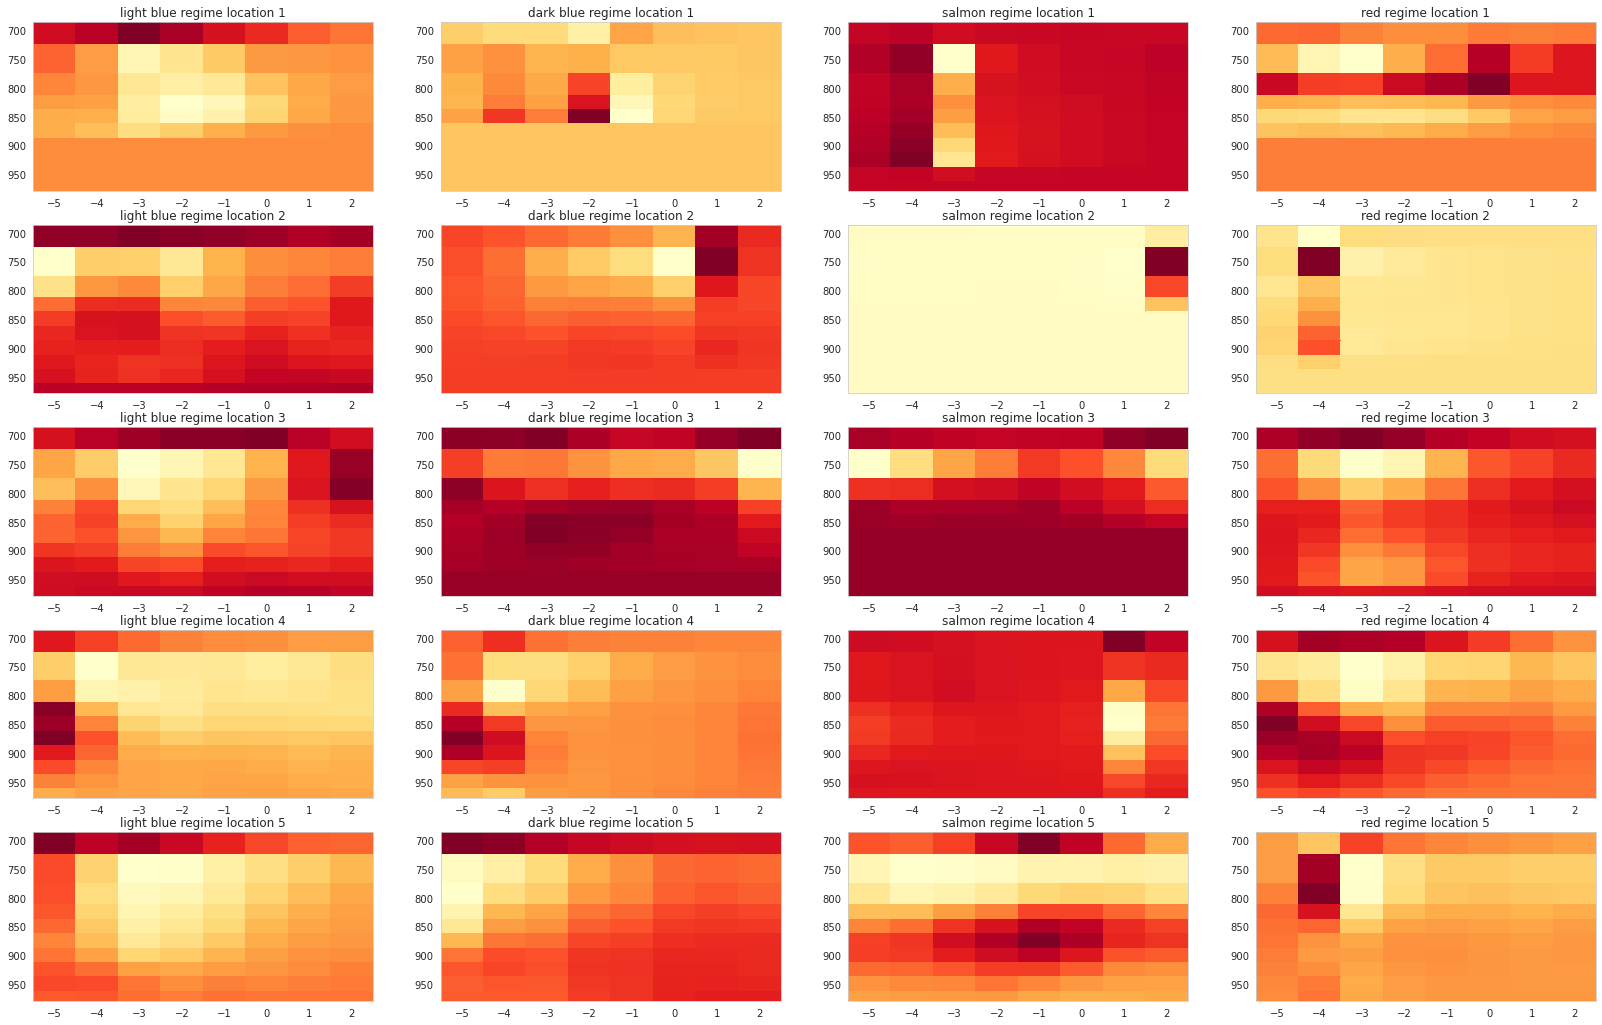

In [25]:
fig, ax = plt.subplots(5, 4, figsize = (28, 18))
  
for col, regime in enumerate(coords.keys()):
    for row, (lat, lon) in enumerate(coords[regime]):
        if lon < 0:
            lon = lon + 360

        df = gather_df_anoms(lat,lon)
        lastrow = df.iloc[-1,:]

        display(df)
        display(lastrow)

        firstgraph = df.iloc[:-1,:]/lastrow

        cm = ax[row, col].pcolormesh(np.array(firstgraph.columns),np.array(firstgraph.index) , firstgraph,  cmap ='YlOrRd' ,shading='auto')
        ax[row, col].set_ylim(firstgraph.index[0]-14, firstgraph.index[-1] + 4 )
        ax[row, col].axes.xaxis.set_visible(True)   
        ax[row, col].invert_yaxis()

#         ax[row, col].colorbar(cm)
        
        ax[row, col].set_title(regime + ' regime location ' + str(row+1))

Surface Pressure: 838.5219763443237
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.065438,0.040410,-0.019398,-0.009616,0.079488,0.353880,0.506965,0.451871
750.0,0.053378,0.042551,-0.005823,-0.029220,-0.040599,0.165995,0.396877,0.408004
800.0,0.042087,0.037846,-0.012049,-0.071985,-0.116682,0.065090,0.380679,0.425113
825.0,0.033002,0.029008,-0.010409,-0.061881,-0.082885,0.084907,0.397080,0.431654
850.0,0.032260,0.022308,0.003526,0.031361,0.148554,0.350357,0.555461,0.489347
875.0,0.051478,0.048728,0.048217,0.109344,0.246755,0.412481,0.578505,0.491947
900.0,0.051478,0.048729,0.048219,0.109345,0.246754,0.412480,0.578504,0.491947
925.0,0.051478,0.048729,0.048217,0.109345,0.246755,0.412481,0.578505,0.491946
950.0,0.051479,0.048728,0.048217,0.109344,0.246754,0.412481,0.578505,0.491946
975.0,0.051479,0.048729,0.048218,0.109345,0.246754,0.412481,0.578505,0.491946


-5    0.051479
-4    0.048729
-3    0.048218
-2    0.109345
-1    0.246754
 0    0.412481
 1    0.578505
 2    0.491946
Name: 975.0, dtype: float64

Surface Pressure: 942.3197206518937
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,-0.012513,0.059442,0.069381,0.053580,0.305392,0.669874,0.494019,0.221357
750.0,0.032176,0.105430,0.138328,0.116127,0.343364,0.716744,0.547478,0.281971
800.0,0.118484,0.166245,0.200489,0.232595,0.433984,0.816814,0.608573,0.324632
825.0,0.143469,0.188098,0.225975,0.291054,0.520124,0.914564,0.644521,0.325398
850.0,0.153775,0.186656,0.226325,0.321762,0.601381,1.025480,0.684702,0.311568
875.0,0.157225,0.176094,0.210954,0.330995,0.658990,1.098569,0.722908,0.306691
900.0,0.164039,0.171932,0.195031,0.325809,0.686067,1.150535,0.776630,0.324457
925.0,0.172611,0.172571,0.195470,0.337553,0.707433,1.204500,0.853240,0.359066
950.0,0.190230,0.208296,0.250526,0.416482,0.799140,1.273690,0.909778,0.390695
975.0,0.196648,0.216715,0.259288,0.429114,0.807460,1.276199,0.908769,0.389573


-5    0.196648
-4    0.216715
-3    0.259288
-2    0.429114
-1    0.807460
 0    1.276199
 1    0.908769
 2    0.389573
Name: 975.0, dtype: float64

Surface Pressure: 955.9903703100056
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.068207,0.081713,0.020948,0.057292,0.166009,0.366634,0.569845,0.367042
750.0,0.056719,0.126436,0.037926,0.100242,0.233762,0.435840,0.587258,0.382379
800.0,0.082509,0.159046,0.096440,0.118006,0.289753,0.477162,0.529421,0.309712
825.0,0.091292,0.163226,0.136411,0.139229,0.348526,0.483763,0.507230,0.281204
850.0,0.091121,0.156095,0.158324,0.173672,0.417373,0.506506,0.492695,0.269427
875.0,0.105639,0.165470,0.175504,0.229029,0.500021,0.562629,0.499130,0.269137
900.0,0.117987,0.184880,0.209092,0.284581,0.574451,0.661852,0.545176,0.293005
925.0,0.122532,0.200259,0.241794,0.327754,0.624862,0.741665,0.604492,0.317400
950.0,0.123745,0.202862,0.262480,0.365101,0.662974,0.789448,0.652937,0.333508
975.0,0.132471,0.214318,0.276257,0.385722,0.673898,0.783397,0.653825,0.342729


-5    0.132471
-4    0.214318
-3    0.276257
-2    0.385722
-1    0.673898
 0    0.783397
 1    0.653825
 2    0.342729
Name: 975.0, dtype: float64

Surface Pressure: 981.6633820106065
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.030198,0.027295,0.133160,0.258852,0.475831,0.583170,0.484391,0.278947
750.0,0.041101,0.040644,0.107570,0.248431,0.507973,0.665058,0.522299,0.266396
800.0,0.078551,0.093986,0.134428,0.257865,0.558856,0.762668,0.561253,0.259746
825.0,0.075586,0.124550,0.181416,0.309540,0.627592,0.857348,0.629685,0.296638
850.0,0.079737,0.143304,0.214974,0.382919,0.723678,0.989212,0.719919,0.348607
875.0,0.062722,0.136513,0.236701,0.453723,0.816391,1.101763,0.788404,0.389213
900.0,0.054390,0.124446,0.249765,0.483296,0.870784,1.168070,0.821956,0.399848
925.0,0.046467,0.116126,0.249807,0.486805,0.892610,1.211365,0.858324,0.406043
950.0,0.037724,0.107994,0.249600,0.490745,0.899337,1.236590,0.895903,0.420428
975.0,0.040351,0.108852,0.253871,0.508697,0.907483,1.244344,0.927163,0.440532


-5    0.040351
-4    0.108852
-3    0.253871
-2    0.508697
-1    0.907483
 0    1.244344
 1    0.927163
 2    0.440532
Name: 975.0, dtype: float64

Surface Pressure: 985.3141454538647
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.136387,0.090177,0.011351,0.029699,0.191174,0.588337,0.658652,0.449483
750.0,0.134789,0.075870,0.025866,0.064078,0.228563,0.703035,0.763908,0.503371
800.0,0.130552,0.087245,0.038532,0.101180,0.309556,0.839403,0.868916,0.539541
825.0,0.123252,0.098725,0.046595,0.121543,0.359688,0.931735,0.926303,0.552766
850.0,0.112586,0.110644,0.063450,0.156129,0.424179,1.034683,0.992215,0.576884
875.0,0.118845,0.135720,0.100766,0.205993,0.510436,1.125518,1.055414,0.610228
900.0,0.131804,0.175516,0.160873,0.276470,0.619922,1.212449,1.107097,0.643579
925.0,0.137232,0.196874,0.198715,0.331563,0.717430,1.304371,1.157356,0.656899
950.0,0.129315,0.188893,0.202896,0.353440,0.750066,1.374882,1.197249,0.671304
975.0,0.122404,0.177605,0.205731,0.375929,0.770724,1.432448,1.239590,0.692497


-5    0.122404
-4    0.177605
-3    0.205731
-2    0.375929
-1    0.770724
 0    1.432448
 1    1.239590
 2    0.692497
Name: 975.0, dtype: float64

Surface Pressure: 827.711228854487
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,-0.055869,-0.047818,-0.058285,-0.034435,0.034540,0.170706,0.376317,0.390830
750.0,-0.036036,-0.052296,-0.085488,-0.121966,-0.145645,-0.035748,0.255755,0.317943
800.0,-0.030784,-0.058353,-0.105573,-0.164406,-0.214135,-0.107116,0.227197,0.300802
825.0,-0.053139,-0.091406,-0.166248,-0.233952,-0.270714,-0.092943,0.295173,0.377606
850.0,-0.014638,-0.009434,-0.027196,-0.013609,0.041994,0.228501,0.477070,0.452473
875.0,-0.014641,-0.009435,-0.027198,-0.013611,0.041992,0.228500,0.477070,0.452473
900.0,-0.014640,-0.009435,-0.027197,-0.013610,0.041993,0.228500,0.477070,0.452474
925.0,-0.014640,-0.009435,-0.027196,-0.013610,0.041993,0.228500,0.477070,0.452475
950.0,-0.014640,-0.009435,-0.027196,-0.013610,0.041993,0.228500,0.477071,0.452475
975.0,-0.014640,-0.009435,-0.027196,-0.013610,0.041993,0.228500,0.477071,0.452475


-5   -0.014640
-4   -0.009435
-3   -0.027196
-2   -0.013610
-1    0.041993
 0    0.228500
 1    0.477071
 2    0.452475
Name: 975.0, dtype: float64

Surface Pressure: 915.9014964767993
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,-0.082589,-0.068498,0.011877,0.077613,0.141011,0.192522,0.223582,0.268469
750.0,-0.077022,-0.075062,-0.026281,-0.010209,0.011113,0.057862,0.134677,0.226780
800.0,-0.077860,-0.081052,-0.060373,-0.085524,-0.094333,-0.040951,0.097867,0.224595
825.0,-0.085499,-0.091233,-0.084525,-0.125689,-0.142300,-0.080129,0.094718,0.239677
850.0,-0.091777,-0.102746,-0.109733,-0.163284,-0.184499,-0.106624,0.104791,0.258356
875.0,-0.095020,-0.109771,-0.126117,-0.183355,-0.206975,-0.115300,0.117779,0.266915
900.0,-0.095674,-0.113516,-0.132888,-0.186503,-0.213483,-0.123399,0.109210,0.258860
925.0,-0.097185,-0.115971,-0.133644,-0.179707,-0.205112,-0.123427,0.097884,0.246994
950.0,-0.097378,-0.115744,-0.132842,-0.177741,-0.202267,-0.122304,0.097544,0.246267
975.0,-0.097379,-0.115745,-0.132843,-0.177742,-0.202268,-0.122305,0.097542,0.246266


-5   -0.097379
-4   -0.115745
-3   -0.132843
-2   -0.177742
-1   -0.202268
 0   -0.122305
 1    0.097542
 2    0.246266
Name: 975.0, dtype: float64

Surface Pressure: 908.2894396494083
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,-0.065642,-0.061495,-0.064541,-0.050923,-0.039628,-0.063148,0.026217,0.130919
750.0,-0.128900,-0.138562,-0.115779,-0.150709,-0.220238,-0.408985,-0.236221,-0.008086
800.0,-0.119079,-0.175861,-0.188529,-0.228498,-0.368281,-0.636731,-0.389287,-0.118974
825.0,-0.112950,-0.188107,-0.212294,-0.243200,-0.386765,-0.652002,-0.411392,-0.154106
850.0,-0.115542,-0.192386,-0.213459,-0.243007,-0.375930,-0.636597,-0.415016,-0.182334
875.0,-0.117245,-0.190488,-0.201688,-0.235340,-0.359396,-0.638768,-0.420003,-0.197014
900.0,-0.118804,-0.191120,-0.196604,-0.224578,-0.355042,-0.646215,-0.420427,-0.215412
925.0,-0.124731,-0.194479,-0.198232,-0.231156,-0.370749,-0.678796,-0.444743,-0.229080
950.0,-0.124729,-0.194472,-0.198225,-0.231160,-0.370754,-0.678804,-0.444749,-0.229081
975.0,-0.124729,-0.194472,-0.198225,-0.231160,-0.370754,-0.678804,-0.444749,-0.229081


-5   -0.124729
-4   -0.194472
-3   -0.198225
-2   -0.231160
-1   -0.370754
 0   -0.678804
 1   -0.444749
 2   -0.229081
Name: 975.0, dtype: float64

Surface Pressure: 971.4847862287381
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.027162,-0.014559,-0.079581,-0.108356,0.117150,0.527830,0.688649,0.479308
750.0,0.009775,-0.038038,-0.058146,-0.029855,0.244660,0.650678,0.790943,0.540305
800.0,0.050853,-0.003712,0.020354,0.085825,0.400382,0.805403,0.910103,0.623973
825.0,0.076798,0.032111,0.058463,0.131063,0.432997,0.840008,0.937526,0.650168
850.0,0.092851,0.047296,0.083370,0.141725,0.429545,0.829486,0.933586,0.654218
875.0,0.078744,0.042651,0.091021,0.141432,0.419279,0.818058,0.924438,0.644252
900.0,0.041121,0.030741,0.083524,0.135167,0.421048,0.828508,0.918482,0.620452
925.0,0.008966,0.011668,0.064558,0.121482,0.423459,0.856274,0.917559,0.597795
950.0,-0.002254,-0.007416,0.046797,0.125265,0.444394,0.896228,0.938593,0.580794
975.0,0.023236,0.016551,0.086757,0.198240,0.545451,0.982599,0.965223,0.558250


-5    0.023236
-4    0.016551
-3    0.086757
-2    0.198240
-1    0.545451
 0    0.982599
 1    0.965223
 2    0.558250
Name: 975.0, dtype: float64

Surface Pressure: 968.5015023951091
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,-0.078401,-0.088123,-0.083510,0.028308,0.231369,0.615409,0.530843,0.265008
750.0,-0.087086,-0.053025,-0.048323,0.089318,0.265706,0.670552,0.600521,0.299788
800.0,-0.068030,-0.006468,0.027825,0.194295,0.400574,0.834004,0.732489,0.374724
825.0,-0.049686,0.023937,0.062815,0.246927,0.486117,0.933327,0.796023,0.418869
850.0,-0.004097,0.058515,0.107893,0.307703,0.570544,1.018238,0.849556,0.461675
875.0,0.039871,0.087355,0.141592,0.351522,0.627102,1.073122,0.873425,0.464960
900.0,0.054628,0.092762,0.146320,0.355583,0.638063,1.101937,0.888104,0.465614
925.0,0.049834,0.080598,0.133747,0.341371,0.626833,1.113848,0.910613,0.482686
950.0,0.051360,0.077485,0.132962,0.333288,0.627517,1.121127,0.942398,0.507046
975.0,0.088971,0.131846,0.222795,0.437602,0.768046,1.208481,0.982701,0.531107


-5    0.088971
-4    0.131846
-3    0.222795
-2    0.437602
-1    0.768046
 0    1.208481
 1    0.982701
 2    0.531107
Name: 975.0, dtype: float64

Surface Pressure: 914.4839139023477
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,-0.131175,-0.128039,-0.175332,-0.029678,0.293716,0.649247,0.669418,0.540914
750.0,-0.093693,-0.099853,-0.087582,0.046881,0.269985,0.570119,0.629873,0.501185
800.0,-0.101104,-0.093258,-0.063238,0.037569,0.184859,0.448017,0.591061,0.468880
825.0,-0.106973,-0.105908,-0.074344,0.016108,0.149795,0.410769,0.576463,0.458081
850.0,-0.118182,-0.123127,-0.097783,-0.014866,0.122631,0.392799,0.566758,0.449468
875.0,-0.132620,-0.138205,-0.118230,-0.033459,0.117495,0.393508,0.567295,0.438567
900.0,-0.148931,-0.156057,-0.136886,-0.039199,0.139030,0.404038,0.572545,0.425600
925.0,-0.086312,-0.059015,0.008073,0.210040,0.508112,0.703306,0.693128,0.432095
950.0,-0.081601,-0.053035,0.017744,0.222897,0.518307,0.705018,0.690236,0.427535
975.0,-0.081601,-0.053034,0.017745,0.222897,0.518308,0.705018,0.690236,0.427535


-5   -0.081601
-4   -0.053034
-3    0.017745
-2    0.222897
-1    0.518308
 0    0.705018
 1    0.690236
 2    0.427535
Name: 975.0, dtype: float64

Surface Pressure: 807.1943767788475
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,-0.238679,-0.266952,-0.281280,-0.350448,-0.427811,-0.358907,-0.075080,0.107381
750.0,-0.254752,-0.274318,-0.297892,-0.376928,-0.467815,-0.407948,-0.116140,0.069661
800.0,-0.274024,-0.290162,-0.317353,-0.397653,-0.490208,-0.450471,-0.166659,0.035853
825.0,-0.275257,-0.292150,-0.314685,-0.381938,-0.477812,-0.464713,-0.200546,0.004861
850.0,-0.275250,-0.292143,-0.314677,-0.381931,-0.477805,-0.464706,-0.200539,0.004866
875.0,-0.275250,-0.292143,-0.314677,-0.381931,-0.477806,-0.464707,-0.200540,0.004867
900.0,-0.275250,-0.292144,-0.314678,-0.381932,-0.477806,-0.464707,-0.200540,0.004867
925.0,-0.275250,-0.292143,-0.314678,-0.381932,-0.477805,-0.464707,-0.200540,0.004866
950.0,-0.275250,-0.292144,-0.314678,-0.381932,-0.477806,-0.464707,-0.200541,0.004866
975.0,-0.275250,-0.292144,-0.314678,-0.381932,-0.477806,-0.464707,-0.200541,0.004866


-5   -0.275250
-4   -0.292144
-3   -0.314678
-2   -0.381932
-1   -0.477806
 0   -0.464707
 1   -0.200541
 2    0.004866
Name: 975.0, dtype: float64

Surface Pressure: 825.572960311619
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,-0.216459,-0.317672,-0.445530,-0.625905,-0.858917,-0.909995,-0.662069,-0.399499
750.0,-0.329305,-0.416927,-0.541307,-0.721356,-0.938123,-0.995881,-0.749644,-0.493229
800.0,-0.369032,-0.458026,-0.568853,-0.752116,-0.970499,-1.025497,-0.765187,-0.518380
825.0,-0.369362,-0.463720,-0.578033,-0.761251,-0.970980,-1.049620,-0.798868,-0.556924
850.0,-0.370759,-0.467535,-0.580077,-0.766011,-0.977028,-1.061950,-0.820671,-0.581641
875.0,-0.370760,-0.467536,-0.580078,-0.766012,-0.977029,-1.061950,-0.820671,-0.581641
900.0,-0.370760,-0.467535,-0.580078,-0.766012,-0.977028,-1.061949,-0.820671,-0.581640
925.0,-0.370760,-0.467535,-0.580077,-0.766012,-0.977029,-1.061950,-0.820671,-0.581640
950.0,-0.370759,-0.467535,-0.580077,-0.766011,-0.977028,-1.061950,-0.820671,-0.581640
975.0,-0.370760,-0.467535,-0.580077,-0.766012,-0.977028,-1.061950,-0.820671,-0.581639


-5   -0.370760
-4   -0.467535
-3   -0.580077
-2   -0.766012
-1   -0.977028
 0   -1.061950
 1   -0.820671
 2   -0.581639
Name: 975.0, dtype: float64

Surface Pressure: 1000.7158952435931
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.001072,-0.025025,-0.093666,-0.138522,-0.164788,-0.090675,0.035324,0.074397
750.0,-0.001123,-0.026164,-0.117759,-0.150236,-0.120061,0.052434,0.172579,0.187305
800.0,0.073348,0.043954,-0.012544,-0.047405,0.054767,0.270035,0.361843,0.332853
825.0,0.108299,0.079890,0.044334,0.019676,0.126773,0.308076,0.370665,0.350915
850.0,0.098773,0.074281,0.051729,0.032868,0.138600,0.279351,0.311351,0.296793
875.0,0.048167,0.018683,0.002952,-0.018527,0.069096,0.175192,0.211564,0.205918
900.0,-0.009294,-0.030305,-0.033066,-0.054892,-0.004852,0.071832,0.120508,0.125765
925.0,-0.029579,-0.035603,-0.042331,-0.060833,-0.050401,-0.001387,0.058627,0.063896
950.0,-0.007867,-0.003225,-0.014900,-0.045449,-0.069501,-0.040811,0.031202,0.025682
975.0,-0.008405,-0.011440,-0.020218,-0.052725,-0.088109,-0.081695,-0.003687,-0.011716


-5   -0.008405
-4   -0.011440
-3   -0.020218
-2   -0.052725
-1   -0.088109
 0   -0.081695
 1   -0.003687
 2   -0.011716
Name: 975.0, dtype: float64

Surface Pressure: 985.9539293000547
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.076637,0.046524,0.050127,0.060959,0.094835,0.132214,0.177405,0.123493
750.0,0.118264,0.078527,0.089367,0.113064,0.178263,0.268727,0.305545,0.187972
800.0,0.196571,0.206976,0.254130,0.290761,0.385758,0.540669,0.571458,0.389923
825.0,0.279260,0.308468,0.370515,0.412532,0.515005,0.690447,0.683816,0.482750
850.0,0.341988,0.367287,0.425261,0.464581,0.565857,0.724910,0.694902,0.502875
875.0,0.343517,0.361567,0.396285,0.426163,0.499349,0.628778,0.604955,0.443606
900.0,0.300817,0.318122,0.334046,0.356032,0.394795,0.503922,0.509495,0.376854
925.0,0.261163,0.283187,0.288850,0.300751,0.316136,0.409269,0.446269,0.334089
950.0,0.239702,0.256657,0.260808,0.259466,0.263317,0.351810,0.419144,0.320675
975.0,0.237319,0.245662,0.246892,0.244218,0.271018,0.378925,0.443025,0.334225


-5    0.237319
-4    0.245662
-3    0.246892
-2    0.244218
-1    0.271018
 0    0.378925
 1    0.443025
 2    0.334225
Name: 975.0, dtype: float64

Surface Pressure: 838.0952964566208
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.158803,0.158767,0.180913,0.376541,0.596799,0.966135,1.027214,0.873010
750.0,0.225216,0.262540,0.325149,0.514501,0.744562,1.032166,1.095398,0.871266
800.0,0.164804,0.209827,0.254239,0.362347,0.508507,0.727392,0.901693,0.727722
825.0,0.145801,0.186367,0.219011,0.311549,0.448089,0.641296,0.850892,0.698038
850.0,0.155629,0.205202,0.253371,0.366863,0.525432,0.722578,0.906464,0.730972
875.0,0.183948,0.238505,0.297147,0.421541,0.583171,0.767143,0.930959,0.741927
900.0,0.183950,0.238508,0.297150,0.421543,0.583173,0.767145,0.930961,0.741929
925.0,0.183951,0.238509,0.297151,0.421544,0.583172,0.767145,0.930961,0.741929
950.0,0.183951,0.238508,0.297150,0.421543,0.583172,0.767145,0.930961,0.741929
975.0,0.183950,0.238507,0.297149,0.421543,0.583171,0.767144,0.930960,0.741929


-5    0.183950
-4    0.238507
-3    0.297149
-2    0.421543
-1    0.583171
 0    0.767144
 1    0.930960
 2    0.741929
Name: 975.0, dtype: float64

Surface Pressure: 876.3568825410964
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,-0.059311,-0.119386,-0.123751,-0.096176,0.171943,0.607633,0.666457,0.554453
750.0,-0.009562,-0.022977,0.000757,0.051582,0.229589,0.621360,0.746989,0.625409
800.0,-0.059015,-0.031746,0.020223,0.069374,0.170711,0.519795,0.756227,0.618867
825.0,-0.084041,-0.046078,0.005308,0.057484,0.143925,0.488189,0.755722,0.609219
850.0,-0.101882,-0.060226,-0.016019,0.044265,0.145354,0.488415,0.761383,0.609942
875.0,-0.097886,-0.065756,-0.014390,0.090018,0.314497,0.752247,0.930877,0.670286
900.0,-0.054016,-0.017258,0.081637,0.257193,0.588359,1.028576,1.056980,0.689112
925.0,-0.047129,-0.007233,0.100264,0.285050,0.621524,1.046537,1.060672,0.686032
950.0,-0.047128,-0.007233,0.100264,0.285051,0.621525,1.046537,1.060672,0.686033
975.0,-0.047128,-0.007233,0.100264,0.285051,0.621526,1.046537,1.060672,0.686033


-5   -0.047128
-4   -0.007233
-3    0.100264
-2    0.285051
-1    0.621526
 0    1.046537
 1    1.060672
 2    0.686033
Name: 975.0, dtype: float64

Surface Pressure: 937.8167519810963
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.091192,-0.012586,-0.073220,-0.091202,0.082812,0.556314,0.597796,0.395193
750.0,0.110486,0.049798,-0.000657,0.041698,0.264464,0.718949,0.757191,0.476936
800.0,0.151331,0.111236,0.074174,0.161386,0.428547,0.799411,0.816424,0.505561
825.0,0.161644,0.113827,0.080531,0.162490,0.429230,0.781461,0.778800,0.473714
850.0,0.164320,0.106240,0.069403,0.140471,0.403392,0.749518,0.733403,0.434269
875.0,0.163099,0.097210,0.051449,0.108168,0.367169,0.718808,0.699736,0.411310
900.0,0.158478,0.086200,0.031757,0.073849,0.335451,0.710004,0.702853,0.414987
925.0,0.155544,0.080721,0.031939,0.073598,0.356895,0.765033,0.770592,0.454009
950.0,0.174155,0.123308,0.119670,0.205640,0.526977,0.902223,0.854654,0.489988
975.0,0.176117,0.129805,0.131731,0.223222,0.541966,0.907864,0.855484,0.488122


-5    0.176117
-4    0.129805
-3    0.131731
-2    0.223222
-1    0.541966
 0    0.907864
 1    0.855484
 2    0.488122
Name: 975.0, dtype: float64

Surface Pressure: 984.3076660648521
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,0.034826,0.042468,0.036357,0.100483,0.313544,0.501835,0.586549,0.307733
750.0,0.063815,0.054150,0.040352,0.130938,0.394275,0.632235,0.672781,0.356892
800.0,0.109202,0.106667,0.121905,0.196757,0.505789,0.792798,0.770268,0.396986
825.0,0.119195,0.136563,0.177453,0.250100,0.570461,0.891899,0.840519,0.439754
850.0,0.113328,0.151896,0.218613,0.301753,0.613596,0.950957,0.871731,0.467919
875.0,0.107391,0.152341,0.227760,0.326219,0.627131,0.945303,0.859498,0.470181
900.0,0.096915,0.142125,0.211651,0.324757,0.597969,0.896441,0.826687,0.461162
925.0,0.088379,0.128954,0.191073,0.306283,0.563261,0.854447,0.802388,0.456000
950.0,0.080781,0.113608,0.170116,0.280804,0.531321,0.827518,0.793809,0.456073
975.0,0.072506,0.099411,0.155703,0.270240,0.527854,0.826777,0.796735,0.454537


-5    0.072506
-4    0.099411
-3    0.155703
-2    0.270240
-1    0.527854
 0    0.826777
 1    0.796735
 2    0.454537
Name: 975.0, dtype: float64

Surface Pressure: 980.4106550850437
700.0
750.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0


,-5,-4,-3,-2,-1,0,1,2
700.0,-0.074567,-0.135110,-0.032632,0.096336,0.388138,0.580204,0.408942,0.168641
750.0,-0.091487,-0.147872,-0.030554,0.117671,0.430506,0.672884,0.462764,0.182496
800.0,-0.102209,-0.112240,0.015111,0.233682,0.592819,0.871404,0.613084,0.277320
825.0,-0.099362,-0.077608,0.055712,0.309988,0.701302,1.003611,0.714363,0.324242
850.0,-0.097300,-0.060774,0.086026,0.358790,0.773835,1.092911,0.786733,0.344035
875.0,-0.094071,-0.057156,0.094502,0.366278,0.792516,1.123248,0.812213,0.341323
900.0,-0.091468,-0.064149,0.086409,0.349222,0.771482,1.117831,0.814474,0.332498
925.0,-0.088921,-0.070809,0.081774,0.331918,0.746994,1.109530,0.818003,0.335848
950.0,-0.087042,-0.072664,0.084762,0.329177,0.735063,1.103689,0.824716,0.343739
975.0,-0.078766,-0.058806,0.101175,0.346740,0.745171,1.104226,0.831561,0.342395


-5   -0.078766
-4   -0.058806
-3    0.101175
-2    0.346740
-1    0.745171
 0    1.104226
 1    0.831561
 2    0.342395
Name: 975.0, dtype: float64

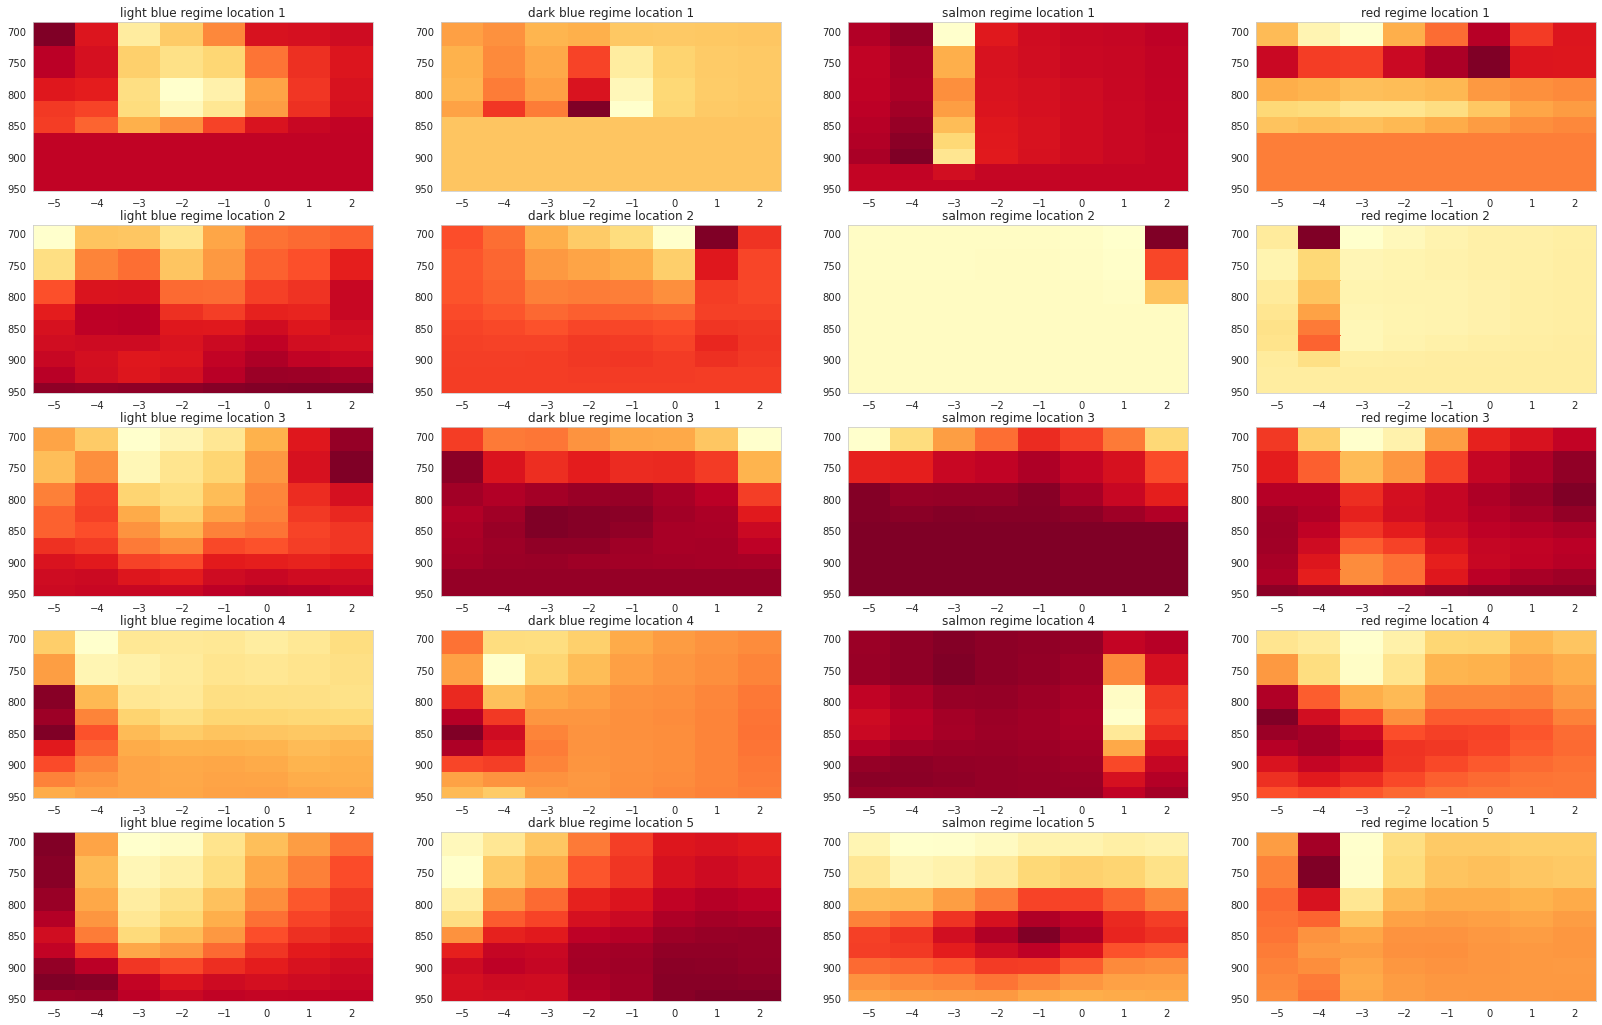

In [47]:
fig, ax = plt.subplots(5, 4, figsize = (28, 18))
  
for col, regime in enumerate(coords.keys()):
    for row, (lat, lon) in enumerate(coords[regime]):
        if lon < 0:
            lon = lon + 360

        df = gather_df_anoms(lat,lon)
        lastrow = df.iloc[-1,:]

        display(df)
        display(lastrow)

        firstgraph = df.iloc[:-1,:]/lastrow

        cm = ax[row, col].pcolormesh(np.array(firstgraph.columns),np.array(firstgraph.index) , firstgraph,  cmap ='YlOrRd' ,shading='auto')
        ax[row, col].set_ylim(firstgraph.index[0]-14, firstgraph.index[-1] + 4 )
        ax[row, col].axes.xaxis.set_visible(True)   
        ax[row, col].invert_yaxis()

#         ax[row, col].colorbar(cm)
        
        ax[row, col].set_title(regime + ' regime location ' + str(row+1))